In [1]:
# KaPy - Reequilibrage des donnees - ClusterCentroids - KNN.ipynb

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from datetime import datetime, timezone, timedelta
from sklearn.metrics import confusion_matrix, classification_report
#import geopandas

# Import des librairies bokeh
from bokeh.models import ColumnDataSource, GeoJSONDataSource, HoverTool
from bokeh.plotting import figure, show
from bokeh.models.widgets import Panel, Tabs
from bokeh.layouts import row,column
from bokeh.io import push_notebook,output_notebook, show
output_notebook()  # pour un affichage dans le notebook

Loading BokehJS ...

In [3]:
# df_final = pd.read_csv(path, index_col=0)
df_final = pd.read_csv("C:\workspaces\Datascientest\MonProjetMeteo\data\weatherAUS_Kapy_v2_20230708.csv",
                       index_col=0,parse_dates=[1])

In [4]:
# Affichage du nombre de valeurs restantes avec un dropna
df_final.dropna(inplace=True)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119115 entries, 3 to 145458
Data columns (total 33 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Date                    119115 non-null  datetime64[ns]
 1   Location                119115 non-null  object        
 2   Rainfall                119115 non-null  float64       
 3   WindGustSpeed           119115 non-null  float64       
 4   Temp9am                 119115 non-null  float64       
 5   RainTomorrow            119115 non-null  float64       
 6   DayOfYear               119115 non-null  int64         
 7   Month                   119115 non-null  int64         
 8   Latitude                119115 non-null  float64       
 9   Longitude               119115 non-null  float64       
 10  diffWind3pm9am          119115 non-null  float64       
 11  diffTempMinMax          119115 non-null  float64       
 12  diffPressure9am3pm      119115

In [5]:
# suppression du lieu, et des coord géographiques
df = df_final.drop(['Date','Location','Latitude','Longitude'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119115 entries, 3 to 145458
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Rainfall                119115 non-null  float64
 1   WindGustSpeed           119115 non-null  float64
 2   Temp9am                 119115 non-null  float64
 3   RainTomorrow            119115 non-null  float64
 4   DayOfYear               119115 non-null  int64  
 5   Month                   119115 non-null  int64  
 6   diffWind3pm9am          119115 non-null  float64
 7   diffTempMinMax          119115 non-null  float64
 8   diffPressure9am3pm      119115 non-null  float64
 9   Pressure                119115 non-null  float64
 10  DeltaP_1d               119115 non-null  float64
 11  DeltaP_2d               119115 non-null  float64
 12  DeltaP_3d               119115 non-null  float64
 13  diffHimidity9am3pm      119115 non-null  float64
 14  Humidity            

In [6]:
# séparation en features et target
target = df["RainTomorrow"]
features = df.drop("RainTomorrow",axis=1)

features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119115 entries, 3 to 145458
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Rainfall                119115 non-null  float64
 1   WindGustSpeed           119115 non-null  float64
 2   Temp9am                 119115 non-null  float64
 3   DayOfYear               119115 non-null  int64  
 4   Month                   119115 non-null  int64  
 5   diffWind3pm9am          119115 non-null  float64
 6   diffTempMinMax          119115 non-null  float64
 7   diffPressure9am3pm      119115 non-null  float64
 8   Pressure                119115 non-null  float64
 9   DeltaP_1d               119115 non-null  float64
 10  DeltaP_2d               119115 non-null  float64
 11  DeltaP_3d               119115 non-null  float64
 12  diffHimidity9am3pm      119115 non-null  float64
 13  Humidity                119115 non-null  float64
 14  DeltaH_1d           

In [7]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

In [8]:
# séparation en jeux d'entrainement et de test

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = .2, random_state = 42, shuffle = True)
print(X_train.shape)
print(X_test.shape)
print(pd.DataFrame(y_test).value_counts())

(95292, 28)
(23823, 28)
RainTomorrow
0.0             18590
1.0              5233
dtype: int64


In [9]:
from sklearn.preprocessing import MinMaxScaler

# pour plus d'info, voir : https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

minmax = MinMaxScaler()

X_train_minmax = minmax.fit_transform(X_train,y_train)

X_test_minmax = minmax.transform(X_test)

pd.DataFrame(X_train_minmax).describe().transpose().mean()

count    95292.000000
mean         0.321393
std          0.171141
min          0.000000
25%          0.226067
50%          0.279766
75%          0.409257
max          1.000000
dtype: float64

In [10]:
# Simulation KNN simulation du nombre d'échantillons en créant des centroïdes

In [11]:
print(pd.DataFrame(y_train).value_counts())

RainTomorrow
0.0             74428
1.0             20864
dtype: int64


In [12]:
# jeux de données d'entrainement
df_minmax = pd.DataFrame(X_train_minmax,y_train.index)

df_minmax["RainTomorrow"] = y_train

df_minmax

0         1         2         3         4         5         6  \
77925   0.000000  0.145161  0.427553  0.306849  0.272727  0.549550  0.162465   
12745   0.000000  0.266129  0.591449  0.857534  0.909091  0.396396  0.492997   
66661   0.000000  0.201613  0.501188  0.008219  0.000000  0.549550  0.411765   
57508   0.000000  0.201613  0.353919  0.747945  0.818182  0.594595  0.666667   
95527   0.000000  0.193548  0.684086  0.312329  0.272727  0.567568  0.537815   
...          ...       ...       ...       ...       ...       ...       ...   
92771   0.001088  0.322581  0.714964  0.090411  0.090909  0.495495  0.319328   
134295  0.025571  0.233871  0.266033  0.460274  0.454545  0.540541  0.380952   
127353  0.000000  0.161290  0.382423  0.427397  0.454545  0.522523  0.352941   
891     0.000000  0.112903  0.175772  0.438356  0.454545  0.630631  0.549020   
20314   0.004353  0.250000  0.498812  0.279452  0.272727  0.666667  0.282913   

               7         8         9  ...   19   20   21   22   23   24   25  \
77925   0.530909  0.755663  0.530581  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
12745   0.400000  0.660194  0.483180  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
66661   0.527273  0.647249  0.577982  ...  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
57508   0.581818  0.807443  0.591743  ...  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
95527   0.483636  0.512945  0.532110  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
...          ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
92771   0.494545  0.389968  0.521407  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
134295  0.654545  0.522654  0.539755  ...  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
127353  0.480000  0.737864  0.487768  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
891     0.621818  0.721683  0.610092  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
20314   0.534545  0.710356  0.585627  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0   

         26   27  RainTomorrow  
77925   0.0  1.0           0.0  
12745   0.0  0.0           0.0  
66661   0.0  0.0           0.0  
57508   0.0  0.0           0.0  
95527   0.0  0.0           0.0  
...     ...  ...           ...  
92771   0.0  0.0           1.0  
134295  0.0  0.0           0.0  
127353  0.0  1.0           0.0  
891     0.0  0.0           0.0  
20314   0.0  0.0           0.0  

[95292 rows x 29 columns]

In [13]:
df_pluie = df_minmax[df_minmax["RainTomorrow"]==1]

df_sec = df_minmax[df_minmax["RainTomorrow"]==0]

X_train_minmax_pluie = df_pluie.drop("RainTomorrow",axis=1)

X_train_minmax_sec = df_sec.drop("RainTomorrow",axis=1)

In [14]:
def Accuracy(TP,TN,FP,FN):
    return (TP+TN)/(TP+FP+FN+TN)

def Precision(TP,FP):
    return TP/(TP+FP)

def Recall(TP,FN):
    return TP/(TP+FN)

def F1score(Recall,Precision):
    return 2*(Recall * Precision) / (Recall + Precision)

def Specificity(TN,FP):
    return TN/(TN+FP)

# fonctions de pondération

In [15]:
# utilisation des fonctions prédéfinies sur la pondération des données

# fonction "weights_sqr"
def weights_sqr(d):
    inverse = 1.0 / d.astype(float)
    sqr = np.square(inverse)
    return sqr

# fonction "weights_sqr4"
def weights_sqr4(d):
    sqr2 = weights_sqr(d)
    sqr4 = np.square(sqr2)
    return sqr4

# fonction "weights_sqr8"
def weights_sqr8(d):
    sqr4 = weights_sqr4(d)
    sqr8 = np.square(sqr4)
    return sqr8

In [16]:
# import du classifier
from sklearn.neighbors import KNeighborsClassifier

<h2>KNN sur 500 centroïdes sec et 500 centroïdes pluie</h2>

In [17]:
# KNN sur 500 centroïdes sec et 500 centroïdes pluie

# utilisation de Kmeans pour trouver des centroïdes
from sklearn.cluster import KMeans

# création de n centroïdes à partir des échantillons secs
kmeans_sec = KMeans(n_clusters = 500)

kmeans_sec.fit(X_train_minmax_sec)

# création de n centroïdes à partir des échantillons de pluie
kmeans_pluie = KMeans(n_clusters = 500)

kmeans_pluie.fit(X_train_minmax_pluie)

# Création du jeux d'entrainement à partir des centroïdes

centroids_sec = kmeans_sec.cluster_centers_

print(centroids_sec.shape)

centroids_pluie = kmeans_pluie.cluster_centers_

print(centroids_pluie.shape)

X_train_centroids = np.append(centroids_sec,centroids_pluie,axis=0)

print(X_train_centroids.shape)

C:\Users\plebert1\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\plebert1\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(500, 28)
(500, 28)
(1000, 28)


# simulation knn sur centroïdes 500s, 500p

In [18]:
# simulation knn sur centroïdes 500s, 500p

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

params = {}
params['nb_voisins'] = np.arange(1,21,1)
params['metric'] = ['manhattan','nan_euclidean','minkowski','chebyshev','cosine','euclidean']
params['weights'] = ['uniform','distance','weights_sqr','weights_sqr4','weights_sqr8']

accuracy = []
precision = []
recall = []
f1score = []
specificity = []

CT = []

y = []
for i in np.arange(0,500):
    y.append(0);

for i in np.arange(0,500):
    y.append(1);
    
y_train_centroids = pd.Series(y)

y_predict = pd.DataFrame()

temps_traitement = []
hdebut = datetime.now()
temps_traitement.append(["Début traitement",hdebut])

for i in params['nb_voisins'] :
    for dist in params['metric']:
        for w in params['weights'] :
            
            #initialisation du modèle modèle :            
            if w == 'weights_sqr':
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr, algorithm = "auto", leaf_size = 30, p = 2,
                                       metric = dist, metric_params = None, n_jobs = None)
            elif w == 'weights_sqr4':
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr4, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = dist, metric_params = None, n_jobs = None)
            elif w == 'weights_sqr8':
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr8, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = dist, metric_params = None, n_jobs = None)
            else :
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = w, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = dist, metric_params = None, n_jobs = None)
                 
            knn.fit(X_train_centroids,y_train_centroids)
        
        
            y_p = knn.predict(X_test_minmax)
            y_prob = knn.predict_proba(X_test_minmax)
            
            col = 'pred'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col] = y_p
            
            col_proba = 'proba0zzz'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col_proba] = y_prob[:,0]
            
            col_proba = 'proba1zzz'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col_proba] = y_prob[:,1]
                             
            ct = pd.crosstab(y_test,y_p,rownames=['Realité'],colnames=['Prédiction'])
            tp = ct.iloc[1,1]
            tn = ct.iloc[0,0]
            fp = ct.iloc[0,1]
            fn = ct.iloc[1,0]
            
            acc = Accuracy(tp,tn,fp,fn)
            pre = Precision(tp,fp)
            rec = Recall(tp,fn)
            f1s = F1score(rec,pre)
            spe = Specificity(tn,fp)
            
            CT.append([i,dist,w,tp,tn,fp,fn,acc,pre,rec,f1s,spe])
                             
            accuracy.append([i,dist,w,acc])
            precision.append([i,dist,w,pre])
            recall.append([i,dist,w,rec])
            f1score.append([i,dist,w,f1s])
            specificity.append([i,dist,w,spe])

hfin = datetime.now()

temps_traitement.append(["Fin traitement",hfin])
temps_traitement.append(["Durée traitement",hfin-hdebut])

warnings.filterwarnings("default", category=FutureWarning)

# Sauvegarde des résultats

# pond_var_inf_mut_"
chemin_local = ""
nom_fichier = 'accuracy_kmeans_500s_500p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=accuracy,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'precision_kmeans_500s_500p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=precision,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'recall_kmeans_500s_500p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=recall,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'f1score_kmeans_500s_500p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=f1score,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'specificity_kmeans_500s_500p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=specificity,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'y_predict_kmeans_500s_500p_v1.0.csv'
pd.DataFrame(data=y_predict).to_csv(nom_fichier,sep=',')

nom_fichier = 'crosstab_kmeans_500s_500p_v1.0.csv'
pd.DataFrame(data=CT,
             columns=['k','metric','weights','tp','tn','fp','fn',
                      'acc','pre','rec','f1s','spe']).to_csv(nom_fichier,sep=',')

hsav = datetime.now()
temps_traitement.append(["Fin sauvegarde",hsav])
                         
pd.DataFrame(data=temps_traitement,columns =["Type","Valeur"]).head(10)

'calcul en cours : k=20--metric=euclidean--weights=weights_sqr8'

C:\Users\plebert1\AppData\Local\Temp\ipykernel_21040\554978753.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_predict[col] = y_p
C:\Users\plebert1\AppData\Local\Temp\ipykernel_21040\554978753.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_predict[col_proba] = y_prob[:,0]
C:\Users\plebert1\AppData\Local\Temp\ipykernel_21040\554978753.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

Type                      Valeur
0  Début traitement  2023-07-16 19:37:05.007277
1    Fin traitement  2023-07-16 19:43:06.159062
2  Durée traitement              0:06:01.151785
3    Fin sauvegarde  2023-07-16 19:43:31.342403

# Chargement des données kmeans 500s, 500p

In [19]:
# Chargement des données kmeans 500s, 500p
# charger les indicateurs

chemin_local = ""

nom_fichier = 'accuracy_kmeans_500s_500p_v1.0.csv'
path = chemin_local+nom_fichier
accuracy_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'precision_kmeans_500s_500p_v1.0.csv'
path = chemin_local+nom_fichier
precision_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'recall_kmeans_500s_500p_v1.0.csv'
path = chemin_local+nom_fichier
recall_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'f1score_kmeans_500s_500p_v1.0.csv'
path = chemin_local+nom_fichier
f1score_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'specificity_kmeans_500s_500p_v1.0.csv'
path = chemin_local+nom_fichier
specificity_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'crosstab_kmeans_500s_500p_v1.0.csv'
path = chemin_local+nom_fichier
crosstab_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

accuracy_v1["evaluateur"] = "accuracy_v1"
precision_v1["evaluateur"] = "precision_v1"
recall_v1["evaluateur"] = "recall_v1"
f1score_v1["evaluateur"] = "f1score_v1"
specificity_v1["evaluateur"] = "specificity_v1"

mesures = pd.concat([accuracy_v1,precision_v1,recall_v1,f1score_v1,specificity_v1])

print(accuracy_v1.head(15))
print("\n")

print(precision_v1.head(15))
print("\n")

print(recall_v1.head(15))
print("\n")

print(f1score_v1.head(15))
print("\n")

print(specificity_v1.head(15))
print("\n")

print(crosstab_v1.head(15))

    k         metric       weights    valeur   evaluateur
0   1      manhattan       uniform  0.776015  accuracy_v1
1   1      manhattan      distance  0.776015  accuracy_v1
2   1      manhattan   weights_sqr  0.776015  accuracy_v1
3   1      manhattan  weights_sqr4  0.776015  accuracy_v1
4   1      manhattan  weights_sqr8  0.776015  accuracy_v1
5   1  nan_euclidean       uniform  0.777232  accuracy_v1
6   1  nan_euclidean      distance  0.777232  accuracy_v1
7   1  nan_euclidean   weights_sqr  0.777232  accuracy_v1
8   1  nan_euclidean  weights_sqr4  0.777232  accuracy_v1
9   1  nan_euclidean  weights_sqr8  0.777232  accuracy_v1
10  1      minkowski       uniform  0.777232  accuracy_v1
11  1      minkowski      distance  0.777232  accuracy_v1
12  1      minkowski   weights_sqr  0.777232  accuracy_v1
13  1      minkowski  weights_sqr4  0.777232  accuracy_v1
14  1      minkowski  weights_sqr8  0.777232  accuracy_v1


    k         metric       weights    valeur    evaluateur
0   1      

# Représentation graphique kmeans 500s, 500p

In [20]:
print("Représentation graphique kmeans 500s, 500p")
print("Affichage des courbes de valeur des indicateurs en fonction du nombre de voisins")

import warnings
from bokeh.util.warnings import BokehUserWarning
# warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.simplefilter(action='ignore', category=BokehUserWarning)
warnings.simplefilter(action = 'ignore',category = UserWarning)



# Code Bokeh sans utiliser de boucle : beaucoup plus rapide et zero lag.

from numpy.lib.utils import source
from bokeh.models.widgets import Panel, Tabs
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool,LassoSelectTool
from bokeh.models.ranges import DataRange1d
from bokeh.colors import RGB
from bokeh.models import LinearColorMapper
from  bokeh.models import PanTool,ResetTool,HoverTool,WheelZoomTool,SaveTool,BoxZoomTool
from bokeh.models import Legend

params = {}

params['nb_voisins'] = np.arange(1,21,1)
params['metric'] = ['manhattan','nan_euclidean','minkowski','chebyshev','cosine','euclidean']
params['weights'] = ['uniform','distance','weights_sqr','weights_sqr4','weights_sqr8']
    
mes_couleurs = ['magenta','maroon','mediumaquamarine','mediumblue','mediumorchid','mediumpurple','mediumseagreen',
                'mediumslateblue','mediumspringgreen','mediumturquoise','mediumvioletred','midnightblue','gold',
                'goldenrod','navy','grey','darksalmon','red','magenta','maroon','mediumaquamarine','mediumblue',
                'mediumslateblue','mediumspringgreen','mediumturquoise','mediumvioletred','midnightblue','gold',
                'goldenrod','navy','grey']
# 9 metrics & 2 weights = 18 curves = 18 colors
# https://docs.bokeh.org/en/2.4.2/docs/reference/colors.html#bokeh-colors-named

# Attention : au moins UNE couleur de plus que le nb courbes !!!
# on utilise la couleur supplémentaire pour colorer le pt quand la souris passe dessus


source1 = ColumnDataSource(accuracy_v1)
source2 = ColumnDataSource(precision_v1)
source3 = ColumnDataSource(recall_v1)
source4 = ColumnDataSource(f1score_v1)
source5 = ColumnDataSource(specificity_v1)

tt1 = [("k", "@k"),("metric", "@metric"),("weights","@weights"),("valeur", "@valeur")]

#tools='hover,xpan,xwheel_zoom,box_zoom,save,reset'
tools=[HoverTool(),BoxZoomTool(), PanTool(),ResetTool()]

##################### Accuracy
p1 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Accuracy",
           toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur1 = []
hover1 = []
legend_item1 = []
g1 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(accuracy_v1['metric'].unique()):
    for j,w in enumerate(accuracy_v1['weights'].unique()):
        ma_source = ColumnDataSource(accuracy_v1[(accuracy_v1['metric']==dist) & (accuracy_v1['weights']==w)])
        g1.append(p1.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],
                           line_width=2)) #,legend_label=dist+'--'+w))
        g1.append(p1.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],
                            size=6)) #,legend_label=dist+'--'+w))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur1.append(p1.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7)) #,legend_label=dist+'--'+w))

        hover1.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur1[-1]]))
        legend_item1.append((dist+'--'+w,[g1[-1],g1[-2],chgt_couleur1[-1]]))

p1.legend.visible = False
legend1 = Legend(items=legend_item1,location="center",click_policy="hide")

p1.add_layout(legend1, 'right')

tab1 = Panel(child=p1, title="Accuracy")

##################### Precision
p2 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Precision",
            x_range = p1.x_range,
            toolbar_location = "below",
            tooltips = tt1,tools = tools)

chgt_couleur2 = []
hover2 = []
legend_item2 = []
g2 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(precision_v1['metric'].unique()):
    for j,w in enumerate(precision_v1['weights'].unique()):
        ma_source = ColumnDataSource(precision_v1[(precision_v1['metric']==dist) & (precision_v1['weights']==w)])
        g2.append(p2.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g2.append(p2.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur2.append(p2.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover2.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur2[-1]]))
        legend_item2.append((dist+'--'+w,[g2[-1],g2[-2],chgt_couleur2[-1]]))

p2.legend.visible = False
legend2 = Legend(items=legend_item2,location="center",click_policy="hide")

p2.add_layout(legend2, 'right')

tab2 = Panel(child=p2, title="Precision")

# ##################### Recall
p3 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Recall",
            x_range = p1.x_range,
            toolbar_location = "below",
            tooltips = tt1,tools = tools)

chgt_couleur3 = []
hover3 = []
legend_item3 = []
g3 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(recall_v1['metric'].unique()):
    for j,w in enumerate(recall_v1['weights'].unique()):
        ma_source = ColumnDataSource(recall_v1[(recall_v1['metric']==dist) & (recall_v1['weights']==w)])
        g3.append(p3.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g3.append(p3.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur3.append(p3.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover3.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur3[-1]]))
        legend_item3.append((dist+'--'+w,[g3[-1],g3[-2],chgt_couleur3[-1]]))

p3.legend.visible = False
legend3 = Legend(items=legend_item3,location="center",click_policy="hide")

p3.add_layout(legend3, 'right')

tab3 = Panel(child=p3, title="Recall")

# ##################### F1-Score
p4 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="F1-Score",
            x_range = p1.x_range,
            toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur4 = []
hover4 = []
legend_item4 = []
g4 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(f1score_v1['metric'].unique()):
    for j,w in enumerate(f1score_v1['weights'].unique()):
        ma_source = ColumnDataSource(f1score_v1[(f1score_v1['metric']==dist) & (f1score_v1['weights']==w)])
        g4.append(p4.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g4.append(p4.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur4.append(p4.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover4.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur4[-1]]))
        legend_item4.append((dist+'--'+w,[g4[-1],g4[-2],chgt_couleur4[-1]]))

p4.legend.visible = False
legend4 = Legend(items=legend_item4,location="center",click_policy="hide")

p4.add_layout(legend4, 'right')

tab4 = Panel(child=p4, title="F1-Score")

# ##################### Specificity
p5 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Specificity",
            x_range = p1.x_range,
            toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur5 = []
hover5 = []
legend_item5 = []
g5 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(specificity_v1['metric'].unique()):
    for j,w in enumerate(specificity_v1['weights'].unique()):
        ma_source = ColumnDataSource(specificity_v1[(specificity_v1['metric']==dist) & (specificity_v1['weights']==w)])
        g5.append(p5.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g5.append(p5.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur5.append(p5.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover5.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur5[-1]]))
        legend_item5.append((dist+'--'+w,[g5[-1],g5[-2],chgt_couleur5[-1]]))
        
p5.legend.visible = False
legend5 = Legend(items=legend_item5,location="center",click_policy="hide")

p5.add_layout(legend5, 'right')

tab5 = Panel(child=p5, title="Specificity")

# ##################### Accuracy en fct du F1-Score

p6 = figure(plot_width=800, plot_height=800,x_axis_label='F1-Score', y_axis_label='Accuracy',
#             title="Accuracy en fct du F1-Score",
            toolbar_location = "below",
           x_range = DataRange1d(bounds='auto'),
           y_range = DataRange1d(bounds='auto'))

acc_f1 = accuracy_v1.copy(deep=True)
acc_f1.rename(columns={'valeur':'accuracy'},inplace=True)

acc_f1['f1score'] = f1score_v1['valeur']
acc_f1['precision'] = precision_v1['valeur']
acc_f1['recall'] = recall_v1['valeur']
acc_f1['specificity'] = specificity_v1['valeur']

acc_f1['id_couleur'] = round(30 * (acc_f1['accuracy'] * acc_f1['f1score']),0).astype(int)
# couleurs arbitraires pour différencier :
# les meilleurs compromis F1Score/Accuracy
# les compromis moyens
# les mauvais compromis

source6 = ColumnDataSource(acc_f1)

ma_cmap = LinearColorMapper(palette=mes_couleurs, 
                             low = min(acc_f1['id_couleur']), 
                             high = max(acc_f1['id_couleur']))
            
p6.circle(x='f1score',y='accuracy',
          fill_color= {"field":"id_couleur", "transform":ma_cmap},
          line_color=None,
          source = source6,
          size=6)

# chgt de couleur qd la souris passe sur un pt
chgt_couleur6 = p6.circle(x='f1score',y='accuracy',source = source6,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7)

tt2 = [("k", "@k"),("metric", "@metric"),("weights","@weights"),("f1score", "@f1score"),("accuracy","@accuracy"),
      ("recall","@recall"),("precision","@precision"),("specificity","@specificity")]

hover6 = HoverTool(
        tooltips=tt2,
        mode='mouse',
        renderers=[chgt_couleur6])

p6.add_tools(hover6)

tab6 = Panel(child=p6, title="Accuracy en fct du F1-Score")

# ##################### Affichages

# h = column(row(p1,p2),row(p3,p4),row(p5,p6))
# show(h)

tabs = Tabs(tabs=[tab6,tab1,tab2,tab3,tab4,tab5])

show(tabs)

Représentation graphique kmeans 500s, 500p
Affichage des courbes de valeur des indicateurs en fonction du nombre de voisins


<h2>KNN sur 400 centroïdes sec et 600 centroïdes pluie</h2>

In [21]:
# KNN sur 400 centroïdes sec et 600 centroïdes pluie
# utilisation de Kmeans pour trouver des centroïdes
from sklearn.cluster import KMeans

# création de n centroïdes à partir des échantillons secs
kmeans_sec = KMeans(n_clusters = 400)

kmeans_sec.fit(X_train_minmax_sec)

# création de n centroïdes à partir des échantillons de pluie
kmeans_pluie = KMeans(n_clusters = 600)

kmeans_pluie.fit(X_train_minmax_pluie)

# Création du jeux d'entrainement à partir des centroïdes

centroids_sec = kmeans_sec.cluster_centers_

print(centroids_sec.shape)

centroids_pluie = kmeans_pluie.cluster_centers_

print(centroids_pluie.shape)

X_train_centroids = np.append(centroids_sec,centroids_pluie,axis=0)

print(X_train_centroids.shape)

C:\Users\plebert1\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\plebert1\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(400, 28)
(600, 28)
(1000, 28)


# simulation knn sur centroïdes 400s, 600p

In [22]:
# simulation knn sur centroïdes 400s, 600p
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

params = {}
params['nb_voisins'] = np.arange(1,21,1)
params['metric'] = ['manhattan','nan_euclidean','minkowski','chebyshev','cosine','euclidean']
params['weights'] = ['uniform','distance','weights_sqr','weights_sqr4','weights_sqr8']

accuracy = []
precision = []
recall = []
f1score = []
specificity = []

CT = []

y = []
for i in np.arange(0,400):
    y.append(0);

for i in np.arange(0,600):
    y.append(1);
    
y_train_centroids = pd.Series(y)

y_predict = pd.DataFrame()

temps_traitement = []
hdebut = datetime.now()
temps_traitement.append(["Début traitement",hdebut])

for i in params['nb_voisins'] :
    for dist in params['metric']:
        for w in params['weights'] :
            
            #initialisation du modèle modèle :            
            if w == 'weights_sqr':
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr, algorithm = "auto", leaf_size = 30, p = 2,
                                       metric = dist, metric_params = None, n_jobs = None)
            elif w == 'weights_sqr4':
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr4, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = dist, metric_params = None, n_jobs = None)
            elif w == 'weights_sqr8':
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr8, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = dist, metric_params = None, n_jobs = None)
            else :
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = w, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = dist, metric_params = None, n_jobs = None)
                 
            knn.fit(X_train_centroids,y_train_centroids)
        
        
            y_p = knn.predict(X_test_minmax)
            y_prob = knn.predict_proba(X_test_minmax)
            
            col = 'pred'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col] = y_p
            
            col_proba = 'proba0zzz'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col_proba] = y_prob[:,0]
            
            col_proba = 'proba1zzz'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col_proba] = y_prob[:,1]
                             
            ct = pd.crosstab(y_test,y_p,rownames=['Realité'],colnames=['Prédiction'])
            tp = ct.iloc[1,1]
            tn = ct.iloc[0,0]
            fp = ct.iloc[0,1]
            fn = ct.iloc[1,0]
            
            acc = Accuracy(tp,tn,fp,fn)
            pre = Precision(tp,fp)
            rec = Recall(tp,fn)
            f1s = F1score(rec,pre)
            spe = Specificity(tn,fp)
            
            CT.append([i,dist,w,tp,tn,fp,fn,acc,pre,rec,f1s,spe])
                             
            accuracy.append([i,dist,w,acc])
            precision.append([i,dist,w,pre])
            recall.append([i,dist,w,rec])
            f1score.append([i,dist,w,f1s])
            specificity.append([i,dist,w,spe])

hfin = datetime.now()

temps_traitement.append(["Fin traitement",hfin])
temps_traitement.append(["Durée traitement",hfin-hdebut])

warnings.filterwarnings("default", category=FutureWarning)

# Sauvegarde des résultats

# pond_var_inf_mut_"
chemin_local = ""
nom_fichier = 'accuracy_kmeans_400s_600p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=accuracy,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'precision_kmeans_400s_600p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=precision,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'recall_kmeans_400s_600p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=recall,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'f1score_kmeans_400s_600p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=f1score,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'specificity_kmeans_400s_600p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=specificity,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'y_predict_kmeans_400s_600p_v1.0.csv'
pd.DataFrame(data=y_predict).to_csv(nom_fichier,sep=',')

nom_fichier = 'crosstab_kmeans_400s_600p_v1.0.csv'
pd.DataFrame(data=CT,
             columns=['k','metric','weights','tp','tn','fp','fn',
                      'acc','pre','rec','f1s','spe']).to_csv(nom_fichier,sep=',')

hsav = datetime.now()
temps_traitement.append(["Fin sauvegarde",hsav])
                         
pd.DataFrame(data=temps_traitement,columns =["Type","Valeur"]).head(10)

'calcul en cours : k=20--metric=euclidean--weights=weights_sqr8'

C:\Users\plebert1\AppData\Local\Temp\ipykernel_21040\1842326516.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_predict[col] = y_p
C:\Users\plebert1\AppData\Local\Temp\ipykernel_21040\1842326516.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_predict[col_proba] = y_prob[:,0]
C:\Users\plebert1\AppData\Local\Temp\ipykernel_21040\1842326516.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

Type                      Valeur
0  Début traitement  2023-07-16 19:44:12.563454
1    Fin traitement  2023-07-16 19:50:14.090443
2  Durée traitement              0:06:01.526989
3    Fin sauvegarde  2023-07-16 19:50:41.619932

# Chargement des données kmeans 400s, 600p

In [23]:
# Chargement des données kmeans 400s, 600p
# charger les indicateurs

chemin_local = ""

nom_fichier = 'accuracy_kmeans_400s_600p_v1.0.csv'
path = chemin_local+nom_fichier
accuracy_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'precision_kmeans_400s_600p_v1.0.csv'
path = chemin_local+nom_fichier
precision_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'recall_kmeans_400s_600p_v1.0.csv'
path = chemin_local+nom_fichier
recall_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'f1score_kmeans_400s_600p_v1.0.csv'
path = chemin_local+nom_fichier
f1score_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'specificity_kmeans_400s_600p_v1.0.csv'
path = chemin_local+nom_fichier
specificity_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'crosstab_kmeans_400s_600p_v1.0.csv'
path = chemin_local+nom_fichier
crosstab_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

accuracy_v1["evaluateur"] = "accuracy_v1"
precision_v1["evaluateur"] = "precision_v1"
recall_v1["evaluateur"] = "recall_v1"
f1score_v1["evaluateur"] = "f1score_v1"
specificity_v1["evaluateur"] = "specificity_v1"

mesures = pd.concat([accuracy_v1,precision_v1,recall_v1,f1score_v1,specificity_v1])

print(accuracy_v1.head(15))
print("\n")

print(precision_v1.head(15))
print("\n")

print(recall_v1.head(15))
print("\n")

print(f1score_v1.head(15))
print("\n")

print(specificity_v1.head(15))
print("\n")

print(crosstab_v1.head(15))

    k         metric       weights    valeur   evaluateur
0   1      manhattan       uniform  0.748730  accuracy_v1
1   1      manhattan      distance  0.748730  accuracy_v1
2   1      manhattan   weights_sqr  0.748730  accuracy_v1
3   1      manhattan  weights_sqr4  0.748730  accuracy_v1
4   1      manhattan  weights_sqr8  0.748730  accuracy_v1
5   1  nan_euclidean       uniform  0.751165  accuracy_v1
6   1  nan_euclidean      distance  0.751165  accuracy_v1
7   1  nan_euclidean   weights_sqr  0.751165  accuracy_v1
8   1  nan_euclidean  weights_sqr4  0.751165  accuracy_v1
9   1  nan_euclidean  weights_sqr8  0.751165  accuracy_v1
10  1      minkowski       uniform  0.751165  accuracy_v1
11  1      minkowski      distance  0.751165  accuracy_v1
12  1      minkowski   weights_sqr  0.751165  accuracy_v1
13  1      minkowski  weights_sqr4  0.751165  accuracy_v1
14  1      minkowski  weights_sqr8  0.751165  accuracy_v1


    k         metric       weights    valeur    evaluateur
0   1      

# Représentation graphique kmeans  400s, 600p

In [24]:
print("Représentation graphique kmeans 400s, 600p")
print("Affichage des courbes de valeur des indicateurs en fonction du nombre de voisins")

import warnings
from bokeh.util.warnings import BokehUserWarning
# warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.simplefilter(action='ignore', category=BokehUserWarning)
warnings.simplefilter(action = 'ignore',category = UserWarning)



# Code Bokeh sans utiliser de boucle : beaucoup plus rapide et zero lag.

from numpy.lib.utils import source
from bokeh.models.widgets import Panel, Tabs
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool,LassoSelectTool
from bokeh.models.ranges import DataRange1d
from bokeh.colors import RGB
from bokeh.models import LinearColorMapper
from  bokeh.models import PanTool,ResetTool,HoverTool,WheelZoomTool,SaveTool,BoxZoomTool
from bokeh.models import Legend

params = {}

params['nb_voisins'] = np.arange(1,21,1)
params['metric'] = ['manhattan','nan_euclidean','minkowski','chebyshev','cosine','euclidean']
params['weights'] = ['uniform','distance','weights_sqr','weights_sqr4','weights_sqr8']
    
mes_couleurs = ['magenta','maroon','mediumaquamarine','mediumblue','mediumorchid','mediumpurple','mediumseagreen',
                'mediumslateblue','mediumspringgreen','mediumturquoise','mediumvioletred','midnightblue','gold',
                'goldenrod','navy','grey','darksalmon','red','magenta','maroon','mediumaquamarine','mediumblue',
                'mediumslateblue','mediumspringgreen','mediumturquoise','mediumvioletred','midnightblue','gold',
                'goldenrod','navy','grey']
# 9 metrics & 2 weights = 18 curves = 18 colors
# https://docs.bokeh.org/en/2.4.2/docs/reference/colors.html#bokeh-colors-named

# Attention : au moins UNE couleur de plus que le nb courbes !!!
# on utilise la couleur supplémentaire pour colorer le pt quand la souris passe dessus


source1 = ColumnDataSource(accuracy_v1)
source2 = ColumnDataSource(precision_v1)
source3 = ColumnDataSource(recall_v1)
source4 = ColumnDataSource(f1score_v1)
source5 = ColumnDataSource(specificity_v1)

tt1 = [("k", "@k"),("metric", "@metric"),("weights","@weights"),("valeur", "@valeur")]

#tools='hover,xpan,xwheel_zoom,box_zoom,save,reset'
tools=[HoverTool(),BoxZoomTool(), PanTool(),ResetTool()]

##################### Accuracy
p1 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Accuracy",
           toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur1 = []
hover1 = []
legend_item1 = []
g1 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(accuracy_v1['metric'].unique()):
    for j,w in enumerate(accuracy_v1['weights'].unique()):
        ma_source = ColumnDataSource(accuracy_v1[(accuracy_v1['metric']==dist) & (accuracy_v1['weights']==w)])
        g1.append(p1.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],
                           line_width=2)) #,legend_label=dist+'--'+w))
        g1.append(p1.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],
                            size=6)) #,legend_label=dist+'--'+w))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur1.append(p1.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7)) #,legend_label=dist+'--'+w))

        hover1.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur1[-1]]))
        legend_item1.append((dist+'--'+w,[g1[-1],g1[-2],chgt_couleur1[-1]]))

p1.legend.visible = False
legend1 = Legend(items=legend_item1,location="center",click_policy="hide")

p1.add_layout(legend1, 'right')

tab1 = Panel(child=p1, title="Accuracy")

##################### Precision
p2 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Precision",
            x_range = p1.x_range,
            toolbar_location = "below",
            tooltips = tt1,tools = tools)

chgt_couleur2 = []
hover2 = []
legend_item2 = []
g2 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(precision_v1['metric'].unique()):
    for j,w in enumerate(precision_v1['weights'].unique()):
        ma_source = ColumnDataSource(precision_v1[(precision_v1['metric']==dist) & (precision_v1['weights']==w)])
        g2.append(p2.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g2.append(p2.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur2.append(p2.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover2.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur2[-1]]))
        legend_item2.append((dist+'--'+w,[g2[-1],g2[-2],chgt_couleur2[-1]]))

p2.legend.visible = False
legend2 = Legend(items=legend_item2,location="center",click_policy="hide")

p2.add_layout(legend2, 'right')

tab2 = Panel(child=p2, title="Precision")

# ##################### Recall
p3 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Recall",
            x_range = p1.x_range,
            toolbar_location = "below",
            tooltips = tt1,tools = tools)

chgt_couleur3 = []
hover3 = []
legend_item3 = []
g3 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(recall_v1['metric'].unique()):
    for j,w in enumerate(recall_v1['weights'].unique()):
        ma_source = ColumnDataSource(recall_v1[(recall_v1['metric']==dist) & (recall_v1['weights']==w)])
        g3.append(p3.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g3.append(p3.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur3.append(p3.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover3.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur3[-1]]))
        legend_item3.append((dist+'--'+w,[g3[-1],g3[-2],chgt_couleur3[-1]]))

p3.legend.visible = False
legend3 = Legend(items=legend_item3,location="center",click_policy="hide")

p3.add_layout(legend3, 'right')

tab3 = Panel(child=p3, title="Recall")

# ##################### F1-Score
p4 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="F1-Score",
            x_range = p1.x_range,
            toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur4 = []
hover4 = []
legend_item4 = []
g4 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(f1score_v1['metric'].unique()):
    for j,w in enumerate(f1score_v1['weights'].unique()):
        ma_source = ColumnDataSource(f1score_v1[(f1score_v1['metric']==dist) & (f1score_v1['weights']==w)])
        g4.append(p4.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g4.append(p4.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur4.append(p4.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover4.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur4[-1]]))
        legend_item4.append((dist+'--'+w,[g4[-1],g4[-2],chgt_couleur4[-1]]))

p4.legend.visible = False
legend4 = Legend(items=legend_item4,location="center",click_policy="hide")

p4.add_layout(legend4, 'right')

tab4 = Panel(child=p4, title="F1-Score")

# ##################### Specificity
p5 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Specificity",
            x_range = p1.x_range,
            toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur5 = []
hover5 = []
legend_item5 = []
g5 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(specificity_v1['metric'].unique()):
    for j,w in enumerate(specificity_v1['weights'].unique()):
        ma_source = ColumnDataSource(specificity_v1[(specificity_v1['metric']==dist) & (specificity_v1['weights']==w)])
        g5.append(p5.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g5.append(p5.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur5.append(p5.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover5.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur5[-1]]))
        legend_item5.append((dist+'--'+w,[g5[-1],g5[-2],chgt_couleur5[-1]]))
        
p5.legend.visible = False
legend5 = Legend(items=legend_item5,location="center",click_policy="hide")

p5.add_layout(legend5, 'right')

tab5 = Panel(child=p5, title="Specificity")

# ##################### Accuracy en fct du F1-Score

p6 = figure(plot_width=800, plot_height=800,x_axis_label='F1-Score', y_axis_label='Accuracy',
#             title="Accuracy en fct du F1-Score",
            toolbar_location = "below",
           x_range = DataRange1d(bounds='auto'),
           y_range = DataRange1d(bounds='auto'))

acc_f1 = accuracy_v1.copy(deep=True)
acc_f1.rename(columns={'valeur':'accuracy'},inplace=True)

acc_f1['f1score'] = f1score_v1['valeur']
acc_f1['precision'] = precision_v1['valeur']
acc_f1['recall'] = recall_v1['valeur']
acc_f1['specificity'] = specificity_v1['valeur']

acc_f1['id_couleur'] = round(30 * (acc_f1['accuracy'] * acc_f1['f1score']),0).astype(int)
# couleurs arbitraires pour différencier :
# les meilleurs compromis F1Score/Accuracy
# les compromis moyens
# les mauvais compromis

source6 = ColumnDataSource(acc_f1)

ma_cmap = LinearColorMapper(palette=mes_couleurs, 
                             low = min(acc_f1['id_couleur']), 
                             high = max(acc_f1['id_couleur']))
            
p6.circle(x='f1score',y='accuracy',
          fill_color= {"field":"id_couleur", "transform":ma_cmap},
          line_color=None,
          source = source6,
          size=6)

# chgt de couleur qd la souris passe sur un pt
chgt_couleur6 = p6.circle(x='f1score',y='accuracy',source = source6,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7)

tt2 = [("k", "@k"),("metric", "@metric"),("weights","@weights"),("f1score", "@f1score"),("accuracy","@accuracy"),
      ("recall","@recall"),("precision","@precision"),("specificity","@specificity")]

hover6 = HoverTool(
        tooltips=tt2,
        mode='mouse',
        renderers=[chgt_couleur6])

p6.add_tools(hover6)

tab6 = Panel(child=p6, title="Accuracy en fct du F1-Score")

# ##################### Affichages

# h = column(row(p1,p2),row(p3,p4),row(p5,p6))
# show(h)

tabs = Tabs(tabs=[tab6,tab1,tab2,tab3,tab4,tab5])

show(tabs)

Représentation graphique kmeans 400s, 600p
Affichage des courbes de valeur des indicateurs en fonction du nombre de voisins


<h2>KNN sur 200 centroïdes sec et 800 centroïdes pluie</h2>

In [25]:
# KNN sur 200 centroïdes sec et 800 centroïdes pluie
# utilisation de Kmeans pour trouver des centroïdes
from sklearn.cluster import KMeans

# création de n centroïdes à partir des échantillons secs
kmeans_sec = KMeans(n_clusters = 200)

kmeans_sec.fit(X_train_minmax_sec)

# création de n centroïdes à partir des échantillons de pluie
kmeans_pluie = KMeans(n_clusters = 800)

kmeans_pluie.fit(X_train_minmax_pluie)

# Création du jeux d'entrainement à partir des centroïdes

centroids_sec = kmeans_sec.cluster_centers_

print(centroids_sec.shape)

centroids_pluie = kmeans_pluie.cluster_centers_

print(centroids_pluie.shape)

X_train_centroids = np.append(centroids_sec,centroids_pluie,axis=0)

print(X_train_centroids.shape)

C:\Users\plebert1\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\plebert1\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(200, 28)
(800, 28)
(1000, 28)


# simulation knn sur centroïdes 200s, 800p

In [26]:
# simulation knn sur centroïdes 200s, 800p
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

params = {}
params['nb_voisins'] = np.arange(1,21,1)
params['metric'] = ['manhattan','nan_euclidean','minkowski','chebyshev','cosine','euclidean']
params['weights'] = ['uniform','distance','weights_sqr','weights_sqr4','weights_sqr8']

accuracy = []
precision = []
recall = []
f1score = []
specificity = []

CT = []

y = []
for i in np.arange(0,200):
    y.append(0);

for i in np.arange(0,800):
    y.append(1);
    
y_train_centroids = pd.Series(y)

y_predict = pd.DataFrame()

temps_traitement = []
hdebut = datetime.now()
temps_traitement.append(["Début traitement",hdebut])

for i in params['nb_voisins'] :
    for dist in params['metric']:
        for w in params['weights'] :
            
            #initialisation du modèle modèle :            
            if w == 'weights_sqr':
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr, algorithm = "auto", leaf_size = 30, p = 2,
                                       metric = dist, metric_params = None, n_jobs = None)
            elif w == 'weights_sqr4':
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr4, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = dist, metric_params = None, n_jobs = None)
            elif w == 'weights_sqr8':
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr8, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = dist, metric_params = None, n_jobs = None)
            else :
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = w, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = dist, metric_params = None, n_jobs = None)
                 
            knn.fit(X_train_centroids,y_train_centroids)
        
        
            y_p = knn.predict(X_test_minmax)
            y_prob = knn.predict_proba(X_test_minmax)
            
            col = 'pred'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col] = y_p
            
            col_proba = 'proba0zzz'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col_proba] = y_prob[:,0]
            
            col_proba = 'proba1zzz'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col_proba] = y_prob[:,1]
                             
            ct = pd.crosstab(y_test,y_p,rownames=['Realité'],colnames=['Prédiction'])
            tp = ct.iloc[1,1]
            tn = ct.iloc[0,0]
            fp = ct.iloc[0,1]
            fn = ct.iloc[1,0]
            
            acc = Accuracy(tp,tn,fp,fn)
            pre = Precision(tp,fp)
            rec = Recall(tp,fn)
            f1s = F1score(rec,pre)
            spe = Specificity(tn,fp)
            
            CT.append([i,dist,w,tp,tn,fp,fn,acc,pre,rec,f1s,spe])
                             
            accuracy.append([i,dist,w,acc])
            precision.append([i,dist,w,pre])
            recall.append([i,dist,w,rec])
            f1score.append([i,dist,w,f1s])
            specificity.append([i,dist,w,spe])

hfin = datetime.now()

temps_traitement.append(["Fin traitement",hfin])
temps_traitement.append(["Durée traitement",hfin-hdebut])

warnings.filterwarnings("default", category=FutureWarning)

# Sauvegarde des résultats

# pond_var_inf_mut_"
chemin_local = ""
nom_fichier = 'accuracy_kmeans_200s_800p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=accuracy,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'precision_kmeans_200s_800p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=precision,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'recall_kmeans_200s_800p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=recall,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'f1score_kmeans_200s_800p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=f1score,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'specificity_kmeans_200s_800p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=specificity,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'y_predict_kmeans_200s_800p_v1.0.csv'
pd.DataFrame(data=y_predict).to_csv(nom_fichier,sep=',')

nom_fichier = 'crosstab_kmeans_200s_800p_v1.0.csv'
pd.DataFrame(data=CT,
             columns=['k','metric','weights','tp','tn','fp','fn',
                      'acc','pre','rec','f1s','spe']).to_csv(nom_fichier,sep=',')

hsav = datetime.now()
temps_traitement.append(["Fin sauvegarde",hsav])
                         
pd.DataFrame(data=temps_traitement,columns =["Type","Valeur"]).head(10)

'calcul en cours : k=20--metric=euclidean--weights=weights_sqr8'

C:\Users\plebert1\AppData\Local\Temp\ipykernel_21040\3674636752.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_predict[col] = y_p
C:\Users\plebert1\AppData\Local\Temp\ipykernel_21040\3674636752.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_predict[col_proba] = y_prob[:,0]
C:\Users\plebert1\AppData\Local\Temp\ipykernel_21040\3674636752.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

Type                      Valeur
0  Début traitement  2023-07-16 19:51:13.975068
1    Fin traitement  2023-07-16 19:57:13.003353
2  Durée traitement              0:05:59.028285
3    Fin sauvegarde  2023-07-16 19:57:36.759023

# Chargement des données kmeans 200s, 800p

In [27]:
# Chargement des données kmeans 200s, 800p
# charger les indicateurs

chemin_local = ""

nom_fichier = 'accuracy_kmeans_200s_800p_v1.0.csv'
path = chemin_local+nom_fichier
accuracy_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'precision_kmeans_200s_800p_v1.0.csv'
path = chemin_local+nom_fichier
precision_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'recall_kmeans_200s_800p_v1.0.csv'
path = chemin_local+nom_fichier
recall_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'f1score_kmeans_200s_800p_v1.0.csv'
path = chemin_local+nom_fichier
f1score_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'specificity_kmeans_200s_800p_v1.0.csv'
path = chemin_local+nom_fichier
specificity_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'crosstab_kmeans_200s_800p_v1.0.csv'
path = chemin_local+nom_fichier
crosstab_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

accuracy_v1["evaluateur"] = "accuracy_v1"
precision_v1["evaluateur"] = "precision_v1"
recall_v1["evaluateur"] = "recall_v1"
f1score_v1["evaluateur"] = "f1score_v1"
specificity_v1["evaluateur"] = "specificity_v1"

mesures = pd.concat([accuracy_v1,precision_v1,recall_v1,f1score_v1,specificity_v1])

print(accuracy_v1.head(15))
print("\n")

print(precision_v1.head(15))
print("\n")

print(recall_v1.head(15))
print("\n")

print(f1score_v1.head(15))
print("\n")

print(specificity_v1.head(15))
print("\n")

print(crosstab_v1.head(15))

    k         metric       weights    valeur   evaluateur
0   1      manhattan       uniform  0.650632  accuracy_v1
1   1      manhattan      distance  0.650632  accuracy_v1
2   1      manhattan   weights_sqr  0.650632  accuracy_v1
3   1      manhattan  weights_sqr4  0.650632  accuracy_v1
4   1      manhattan  weights_sqr8  0.650632  accuracy_v1
5   1  nan_euclidean       uniform  0.659489  accuracy_v1
6   1  nan_euclidean      distance  0.659489  accuracy_v1
7   1  nan_euclidean   weights_sqr  0.659489  accuracy_v1
8   1  nan_euclidean  weights_sqr4  0.659489  accuracy_v1
9   1  nan_euclidean  weights_sqr8  0.659489  accuracy_v1
10  1      minkowski       uniform  0.659489  accuracy_v1
11  1      minkowski      distance  0.659489  accuracy_v1
12  1      minkowski   weights_sqr  0.659489  accuracy_v1
13  1      minkowski  weights_sqr4  0.659489  accuracy_v1
14  1      minkowski  weights_sqr8  0.659489  accuracy_v1


    k         metric       weights   valeur    evaluateur
0   1      m

# Représentation graphique kmeans 200s, 800p

In [28]:
print("Représentation graphique kmeans 200s, 800p")
print("Affichage des courbes de valeur des indicateurs en fonction du nombre de voisins")

import warnings
from bokeh.util.warnings import BokehUserWarning
# warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.simplefilter(action='ignore', category=BokehUserWarning)
warnings.simplefilter(action = 'ignore',category = UserWarning)



# Code Bokeh sans utiliser de boucle : beaucoup plus rapide et zero lag.

from numpy.lib.utils import source
from bokeh.models.widgets import Panel, Tabs
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool,LassoSelectTool
from bokeh.models.ranges import DataRange1d
from bokeh.colors import RGB
from bokeh.models import LinearColorMapper
from  bokeh.models import PanTool,ResetTool,HoverTool,WheelZoomTool,SaveTool,BoxZoomTool
from bokeh.models import Legend

params = {}

params['nb_voisins'] = np.arange(1,21,1)
params['metric'] = ['manhattan','nan_euclidean','minkowski','chebyshev','cosine','euclidean']
params['weights'] = ['uniform','distance','weights_sqr','weights_sqr4','weights_sqr8']
    
mes_couleurs = ['magenta','maroon','mediumaquamarine','mediumblue','mediumorchid','mediumpurple','mediumseagreen',
                'mediumslateblue','mediumspringgreen','mediumturquoise','mediumvioletred','midnightblue','gold',
                'goldenrod','navy','grey','darksalmon','red','magenta','maroon','mediumaquamarine','mediumblue',
                'mediumslateblue','mediumspringgreen','mediumturquoise','mediumvioletred','midnightblue','gold',
                'goldenrod','navy','grey']
# 9 metrics & 2 weights = 18 curves = 18 colors
# https://docs.bokeh.org/en/2.4.2/docs/reference/colors.html#bokeh-colors-named

# Attention : au moins UNE couleur de plus que le nb courbes !!!
# on utilise la couleur supplémentaire pour colorer le pt quand la souris passe dessus


source1 = ColumnDataSource(accuracy_v1)
source2 = ColumnDataSource(precision_v1)
source3 = ColumnDataSource(recall_v1)
source4 = ColumnDataSource(f1score_v1)
source5 = ColumnDataSource(specificity_v1)

tt1 = [("k", "@k"),("metric", "@metric"),("weights","@weights"),("valeur", "@valeur")]

#tools='hover,xpan,xwheel_zoom,box_zoom,save,reset'
tools=[HoverTool(),BoxZoomTool(), PanTool(),ResetTool()]

##################### Accuracy
p1 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Accuracy",
           toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur1 = []
hover1 = []
legend_item1 = []
g1 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(accuracy_v1['metric'].unique()):
    for j,w in enumerate(accuracy_v1['weights'].unique()):
        ma_source = ColumnDataSource(accuracy_v1[(accuracy_v1['metric']==dist) & (accuracy_v1['weights']==w)])
        g1.append(p1.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],
                           line_width=2)) #,legend_label=dist+'--'+w))
        g1.append(p1.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],
                            size=6)) #,legend_label=dist+'--'+w))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur1.append(p1.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7)) #,legend_label=dist+'--'+w))

        hover1.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur1[-1]]))
        legend_item1.append((dist+'--'+w,[g1[-1],g1[-2],chgt_couleur1[-1]]))

p1.legend.visible = False
legend1 = Legend(items=legend_item1,location="center",click_policy="hide")

p1.add_layout(legend1, 'right')

tab1 = Panel(child=p1, title="Accuracy")

##################### Precision
p2 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Precision",
            x_range = p1.x_range,
            toolbar_location = "below",
            tooltips = tt1,tools = tools)

chgt_couleur2 = []
hover2 = []
legend_item2 = []
g2 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(precision_v1['metric'].unique()):
    for j,w in enumerate(precision_v1['weights'].unique()):
        ma_source = ColumnDataSource(precision_v1[(precision_v1['metric']==dist) & (precision_v1['weights']==w)])
        g2.append(p2.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g2.append(p2.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur2.append(p2.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover2.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur2[-1]]))
        legend_item2.append((dist+'--'+w,[g2[-1],g2[-2],chgt_couleur2[-1]]))

p2.legend.visible = False
legend2 = Legend(items=legend_item2,location="center",click_policy="hide")

p2.add_layout(legend2, 'right')

tab2 = Panel(child=p2, title="Precision")

# ##################### Recall
p3 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Recall",
            x_range = p1.x_range,
            toolbar_location = "below",
            tooltips = tt1,tools = tools)

chgt_couleur3 = []
hover3 = []
legend_item3 = []
g3 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(recall_v1['metric'].unique()):
    for j,w in enumerate(recall_v1['weights'].unique()):
        ma_source = ColumnDataSource(recall_v1[(recall_v1['metric']==dist) & (recall_v1['weights']==w)])
        g3.append(p3.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g3.append(p3.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur3.append(p3.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover3.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur3[-1]]))
        legend_item3.append((dist+'--'+w,[g3[-1],g3[-2],chgt_couleur3[-1]]))

p3.legend.visible = False
legend3 = Legend(items=legend_item3,location="center",click_policy="hide")

p3.add_layout(legend3, 'right')

tab3 = Panel(child=p3, title="Recall")

# ##################### F1-Score
p4 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="F1-Score",
            x_range = p1.x_range,
            toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur4 = []
hover4 = []
legend_item4 = []
g4 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(f1score_v1['metric'].unique()):
    for j,w in enumerate(f1score_v1['weights'].unique()):
        ma_source = ColumnDataSource(f1score_v1[(f1score_v1['metric']==dist) & (f1score_v1['weights']==w)])
        g4.append(p4.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g4.append(p4.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur4.append(p4.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover4.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur4[-1]]))
        legend_item4.append((dist+'--'+w,[g4[-1],g4[-2],chgt_couleur4[-1]]))

p4.legend.visible = False
legend4 = Legend(items=legend_item4,location="center",click_policy="hide")

p4.add_layout(legend4, 'right')

tab4 = Panel(child=p4, title="F1-Score")

# ##################### Specificity
p5 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Specificity",
            x_range = p1.x_range,
            toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur5 = []
hover5 = []
legend_item5 = []
g5 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(specificity_v1['metric'].unique()):
    for j,w in enumerate(specificity_v1['weights'].unique()):
        ma_source = ColumnDataSource(specificity_v1[(specificity_v1['metric']==dist) & (specificity_v1['weights']==w)])
        g5.append(p5.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g5.append(p5.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur5.append(p5.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover5.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur5[-1]]))
        legend_item5.append((dist+'--'+w,[g5[-1],g5[-2],chgt_couleur5[-1]]))
        
p5.legend.visible = False
legend5 = Legend(items=legend_item5,location="center",click_policy="hide")

p5.add_layout(legend5, 'right')

tab5 = Panel(child=p5, title="Specificity")

# ##################### Accuracy en fct du F1-Score

p6 = figure(plot_width=800, plot_height=800,x_axis_label='F1-Score', y_axis_label='Accuracy',
#             title="Accuracy en fct du F1-Score",
            toolbar_location = "below",
           x_range = DataRange1d(bounds='auto'),
           y_range = DataRange1d(bounds='auto'))

acc_f1 = accuracy_v1.copy(deep=True)
acc_f1.rename(columns={'valeur':'accuracy'},inplace=True)

acc_f1['f1score'] = f1score_v1['valeur']
acc_f1['precision'] = precision_v1['valeur']
acc_f1['recall'] = recall_v1['valeur']
acc_f1['specificity'] = specificity_v1['valeur']

acc_f1['id_couleur'] = round(30 * (acc_f1['accuracy'] * acc_f1['f1score']),0).astype(int)
# couleurs arbitraires pour différencier :
# les meilleurs compromis F1Score/Accuracy
# les compromis moyens
# les mauvais compromis

source6 = ColumnDataSource(acc_f1)

ma_cmap = LinearColorMapper(palette=mes_couleurs, 
                             low = min(acc_f1['id_couleur']), 
                             high = max(acc_f1['id_couleur']))
            
p6.circle(x='f1score',y='accuracy',
          fill_color= {"field":"id_couleur", "transform":ma_cmap},
          line_color=None,
          source = source6,
          size=6)

# chgt de couleur qd la souris passe sur un pt
chgt_couleur6 = p6.circle(x='f1score',y='accuracy',source = source6,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7)

tt2 = [("k", "@k"),("metric", "@metric"),("weights","@weights"),("f1score", "@f1score"),("accuracy","@accuracy"),
      ("recall","@recall"),("precision","@precision"),("specificity","@specificity")]

hover6 = HoverTool(
        tooltips=tt2,
        mode='mouse',
        renderers=[chgt_couleur6])

p6.add_tools(hover6)

tab6 = Panel(child=p6, title="Accuracy en fct du F1-Score")

# ##################### Affichages

# h = column(row(p1,p2),row(p3,p4),row(p5,p6))
# show(h)

tabs = Tabs(tabs=[tab6,tab1,tab2,tab3,tab4,tab5])

show(tabs)

Représentation graphique kmeans 200s, 800p
Affichage des courbes de valeur des indicateurs en fonction du nombre de voisins


<h1> KNN sur 600 centroïdes sec et 400 centroïdes pluie</h1>

In [29]:
# KNN sur 600 centroïdes sec et 400 centroïdes pluie
# utilisation de Kmeans pour trouver des centroïdes
from sklearn.cluster import KMeans

# création de n centroïdes à partir des échantillons secs
kmeans_sec = KMeans(n_clusters = 600)

kmeans_sec.fit(X_train_minmax_sec)

# création de n centroïdes à partir des échantillons de pluie
kmeans_pluie = KMeans(n_clusters = 400)

kmeans_pluie.fit(X_train_minmax_pluie)

# Création du jeux d'entrainement à partir des centroïdes

centroids_sec = kmeans_sec.cluster_centers_

print(centroids_sec.shape)

centroids_pluie = kmeans_pluie.cluster_centers_

print(centroids_pluie.shape)

X_train_centroids = np.append(centroids_sec,centroids_pluie,axis=0)

print(X_train_centroids.shape)

C:\Users\plebert1\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\plebert1\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(600, 28)
(400, 28)
(1000, 28)


# simulation knn sur centroïdes 600s, 400p

In [30]:
# simulation knn sur centroïdes 600s, 400p
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

params = {}
params['nb_voisins'] = np.arange(1,21,1)
params['metric'] = ['manhattan','nan_euclidean','minkowski','chebyshev','cosine','euclidean']
params['weights'] = ['uniform','distance','weights_sqr','weights_sqr4','weights_sqr8']

accuracy = []
precision = []
recall = []
f1score = []
specificity = []

CT = []

y = []
for i in np.arange(0,600):
    y.append(0);

for i in np.arange(0,400):
    y.append(1);
    
y_train_centroids = pd.Series(y)

y_predict = pd.DataFrame()

temps_traitement = []
hdebut = datetime.now()
temps_traitement.append(["Début traitement",hdebut])

for i in params['nb_voisins'] :
    for dist in params['metric']:
        for w in params['weights'] :
            
            #initialisation du modèle modèle :            
            if w == 'weights_sqr':
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr, algorithm = "auto", leaf_size = 30, p = 2,
                                       metric = dist, metric_params = None, n_jobs = None)
            elif w == 'weights_sqr4':
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr4, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = dist, metric_params = None, n_jobs = None)
            elif w == 'weights_sqr8':
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr8, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = dist, metric_params = None, n_jobs = None)
            else :
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = w, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = dist, metric_params = None, n_jobs = None)
                 
            knn.fit(X_train_centroids,y_train_centroids)
        
        
            y_p = knn.predict(X_test_minmax)
            y_prob = knn.predict_proba(X_test_minmax)
            
            col = 'pred'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col] = y_p
            
            col_proba = 'proba0zzz'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col_proba] = y_prob[:,0]
            
            col_proba = 'proba1zzz'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col_proba] = y_prob[:,1]
                             
            ct = pd.crosstab(y_test,y_p,rownames=['Realité'],colnames=['Prédiction'])
            tp = ct.iloc[1,1]
            tn = ct.iloc[0,0]
            fp = ct.iloc[0,1]
            fn = ct.iloc[1,0]
            
            acc = Accuracy(tp,tn,fp,fn)
            pre = Precision(tp,fp)
            rec = Recall(tp,fn)
            f1s = F1score(rec,pre)
            spe = Specificity(tn,fp)
            
            CT.append([i,dist,w,tp,tn,fp,fn,acc,pre,rec,f1s,spe])
                             
            accuracy.append([i,dist,w,acc])
            precision.append([i,dist,w,pre])
            recall.append([i,dist,w,rec])
            f1score.append([i,dist,w,f1s])
            specificity.append([i,dist,w,spe])

hfin = datetime.now()

temps_traitement.append(["Fin traitement",hfin])
temps_traitement.append(["Durée traitement",hfin-hdebut])

warnings.filterwarnings("default", category=FutureWarning)

# Sauvegarde des résultats

# pond_var_inf_mut_"
chemin_local = ""
nom_fichier = 'accuracy_kmeans_600s_400p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=accuracy,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'precision_kmeans_600s_400p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=precision,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'recall_kmeans_600s_400p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=recall,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'f1score_kmeans_600s_400p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=f1score,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'specificity_kmeans_600s_400p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=specificity,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'y_predict_kmeans_600s_400p_v1.0.csv'
pd.DataFrame(data=y_predict).to_csv(nom_fichier,sep=',')

nom_fichier = 'crosstab_kmeans_600s_400p_v1.0.csv'
pd.DataFrame(data=CT,
             columns=['k','metric','weights','tp','tn','fp','fn',
                      'acc','pre','rec','f1s','spe']).to_csv(nom_fichier,sep=',')

hsav = datetime.now()
temps_traitement.append(["Fin sauvegarde",hsav])
                         
pd.DataFrame(data=temps_traitement,columns =["Type","Valeur"]).head(10)

'calcul en cours : k=20--metric=euclidean--weights=weights_sqr8'

C:\Users\plebert1\AppData\Local\Temp\ipykernel_21040\598520264.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_predict[col] = y_p
C:\Users\plebert1\AppData\Local\Temp\ipykernel_21040\598520264.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_predict[col_proba] = y_prob[:,0]
C:\Users\plebert1\AppData\Local\Temp\ipykernel_21040\598520264.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

Type                      Valeur
0  Début traitement  2023-07-16 19:58:31.282762
1    Fin traitement  2023-07-16 20:04:37.584044
2  Durée traitement              0:06:06.301282
3    Fin sauvegarde  2023-07-16 20:05:03.928129

# Chargement des données kmeans 600s, 400p

In [31]:
# Chargement des données kmeans 600s, 400p
# charger les indicateurs

chemin_local = ""

nom_fichier = 'accuracy_kmeans_600s_400p_v1.0.csv'
path = chemin_local+nom_fichier
accuracy_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'precision_kmeans_600s_400p_v1.0.csv'
path = chemin_local+nom_fichier
precision_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'recall_kmeans_600s_400p_v1.0.csv'
path = chemin_local+nom_fichier
recall_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'f1score_kmeans_600s_400p_v1.0.csv'
path = chemin_local+nom_fichier
f1score_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'specificity_kmeans_600s_400p_v1.0.csv'
path = chemin_local+nom_fichier
specificity_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'crosstab_kmeans_600s_400p_v1.0.csv'
path = chemin_local+nom_fichier
crosstab_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

accuracy_v1["evaluateur"] = "accuracy_v1"
precision_v1["evaluateur"] = "precision_v1"
recall_v1["evaluateur"] = "recall_v1"
f1score_v1["evaluateur"] = "f1score_v1"
specificity_v1["evaluateur"] = "specificity_v1"

mesures = pd.concat([accuracy_v1,precision_v1,recall_v1,f1score_v1,specificity_v1])

print(accuracy_v1.head(15))
print("\n")

print(precision_v1.head(15))
print("\n")

print(recall_v1.head(15))
print("\n")

print(f1score_v1.head(15))
print("\n")

print(specificity_v1.head(15))
print("\n")

print(crosstab_v1.head(15))

    k         metric       weights    valeur   evaluateur
0   1      manhattan       uniform  0.797675  accuracy_v1
1   1      manhattan      distance  0.797675  accuracy_v1
2   1      manhattan   weights_sqr  0.797675  accuracy_v1
3   1      manhattan  weights_sqr4  0.797675  accuracy_v1
4   1      manhattan  weights_sqr8  0.797675  accuracy_v1
5   1  nan_euclidean       uniform  0.797675  accuracy_v1
6   1  nan_euclidean      distance  0.797675  accuracy_v1
7   1  nan_euclidean   weights_sqr  0.797675  accuracy_v1
8   1  nan_euclidean  weights_sqr4  0.797675  accuracy_v1
9   1  nan_euclidean  weights_sqr8  0.797675  accuracy_v1
10  1      minkowski       uniform  0.797675  accuracy_v1
11  1      minkowski      distance  0.797675  accuracy_v1
12  1      minkowski   weights_sqr  0.797675  accuracy_v1
13  1      minkowski  weights_sqr4  0.797675  accuracy_v1
14  1      minkowski  weights_sqr8  0.797675  accuracy_v1


    k         metric       weights    valeur    evaluateur
0   1      

# Représentation graphique kmeans 600s, 400p

In [32]:
print("Représentation graphique kmeans 600s, 400p")
print("Affichage des courbes de valeur des indicateurs en fonction du nombre de voisins")

import warnings
from bokeh.util.warnings import BokehUserWarning
# warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.simplefilter(action='ignore', category=BokehUserWarning)
warnings.simplefilter(action = 'ignore',category = UserWarning)



# Code Bokeh sans utiliser de boucle : beaucoup plus rapide et zero lag.

from numpy.lib.utils import source
from bokeh.models.widgets import Panel, Tabs
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool,LassoSelectTool
from bokeh.models.ranges import DataRange1d
from bokeh.colors import RGB
from bokeh.models import LinearColorMapper
from  bokeh.models import PanTool,ResetTool,HoverTool,WheelZoomTool,SaveTool,BoxZoomTool
from bokeh.models import Legend

params = {}

params['nb_voisins'] = np.arange(1,21,1)
params['metric'] = ['manhattan','nan_euclidean','minkowski','chebyshev','cosine','euclidean']
params['weights'] = ['uniform','distance','weights_sqr','weights_sqr4','weights_sqr8']
    
mes_couleurs = ['magenta','maroon','mediumaquamarine','mediumblue','mediumorchid','mediumpurple','mediumseagreen',
                'mediumslateblue','mediumspringgreen','mediumturquoise','mediumvioletred','midnightblue','gold',
                'goldenrod','navy','grey','darksalmon','red','magenta','maroon','mediumaquamarine','mediumblue',
                'mediumslateblue','mediumspringgreen','mediumturquoise','mediumvioletred','midnightblue','gold',
                'goldenrod','navy','grey']
# 9 metrics & 2 weights = 18 curves = 18 colors
# https://docs.bokeh.org/en/2.4.2/docs/reference/colors.html#bokeh-colors-named

# Attention : au moins UNE couleur de plus que le nb courbes !!!
# on utilise la couleur supplémentaire pour colorer le pt quand la souris passe dessus


source1 = ColumnDataSource(accuracy_v1)
source2 = ColumnDataSource(precision_v1)
source3 = ColumnDataSource(recall_v1)
source4 = ColumnDataSource(f1score_v1)
source5 = ColumnDataSource(specificity_v1)

tt1 = [("k", "@k"),("metric", "@metric"),("weights","@weights"),("valeur", "@valeur")]

#tools='hover,xpan,xwheel_zoom,box_zoom,save,reset'
tools=[HoverTool(),BoxZoomTool(), PanTool(),ResetTool()]

##################### Accuracy
p1 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Accuracy",
           toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur1 = []
hover1 = []
legend_item1 = []
g1 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(accuracy_v1['metric'].unique()):
    for j,w in enumerate(accuracy_v1['weights'].unique()):
        ma_source = ColumnDataSource(accuracy_v1[(accuracy_v1['metric']==dist) & (accuracy_v1['weights']==w)])
        g1.append(p1.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],
                           line_width=2)) #,legend_label=dist+'--'+w))
        g1.append(p1.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],
                            size=6)) #,legend_label=dist+'--'+w))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur1.append(p1.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7)) #,legend_label=dist+'--'+w))

        hover1.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur1[-1]]))
        legend_item1.append((dist+'--'+w,[g1[-1],g1[-2],chgt_couleur1[-1]]))

p1.legend.visible = False
legend1 = Legend(items=legend_item1,location="center",click_policy="hide")

p1.add_layout(legend1, 'right')

tab1 = Panel(child=p1, title="Accuracy")

##################### Precision
p2 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Precision",
            x_range = p1.x_range,
            toolbar_location = "below",
            tooltips = tt1,tools = tools)

chgt_couleur2 = []
hover2 = []
legend_item2 = []
g2 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(precision_v1['metric'].unique()):
    for j,w in enumerate(precision_v1['weights'].unique()):
        ma_source = ColumnDataSource(precision_v1[(precision_v1['metric']==dist) & (precision_v1['weights']==w)])
        g2.append(p2.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g2.append(p2.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur2.append(p2.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover2.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur2[-1]]))
        legend_item2.append((dist+'--'+w,[g2[-1],g2[-2],chgt_couleur2[-1]]))

p2.legend.visible = False
legend2 = Legend(items=legend_item2,location="center",click_policy="hide")

p2.add_layout(legend2, 'right')

tab2 = Panel(child=p2, title="Precision")

# ##################### Recall
p3 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Recall",
            x_range = p1.x_range,
            toolbar_location = "below",
            tooltips = tt1,tools = tools)

chgt_couleur3 = []
hover3 = []
legend_item3 = []
g3 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(recall_v1['metric'].unique()):
    for j,w in enumerate(recall_v1['weights'].unique()):
        ma_source = ColumnDataSource(recall_v1[(recall_v1['metric']==dist) & (recall_v1['weights']==w)])
        g3.append(p3.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g3.append(p3.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur3.append(p3.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover3.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur3[-1]]))
        legend_item3.append((dist+'--'+w,[g3[-1],g3[-2],chgt_couleur3[-1]]))

p3.legend.visible = False
legend3 = Legend(items=legend_item3,location="center",click_policy="hide")

p3.add_layout(legend3, 'right')

tab3 = Panel(child=p3, title="Recall")

# ##################### F1-Score
p4 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="F1-Score",
            x_range = p1.x_range,
            toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur4 = []
hover4 = []
legend_item4 = []
g4 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(f1score_v1['metric'].unique()):
    for j,w in enumerate(f1score_v1['weights'].unique()):
        ma_source = ColumnDataSource(f1score_v1[(f1score_v1['metric']==dist) & (f1score_v1['weights']==w)])
        g4.append(p4.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g4.append(p4.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur4.append(p4.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover4.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur4[-1]]))
        legend_item4.append((dist+'--'+w,[g4[-1],g4[-2],chgt_couleur4[-1]]))

p4.legend.visible = False
legend4 = Legend(items=legend_item4,location="center",click_policy="hide")

p4.add_layout(legend4, 'right')

tab4 = Panel(child=p4, title="F1-Score")

# ##################### Specificity
p5 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Specificity",
            x_range = p1.x_range,
            toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur5 = []
hover5 = []
legend_item5 = []
g5 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(specificity_v1['metric'].unique()):
    for j,w in enumerate(specificity_v1['weights'].unique()):
        ma_source = ColumnDataSource(specificity_v1[(specificity_v1['metric']==dist) & (specificity_v1['weights']==w)])
        g5.append(p5.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g5.append(p5.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur5.append(p5.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover5.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur5[-1]]))
        legend_item5.append((dist+'--'+w,[g5[-1],g5[-2],chgt_couleur5[-1]]))
        
p5.legend.visible = False
legend5 = Legend(items=legend_item5,location="center",click_policy="hide")

p5.add_layout(legend5, 'right')

tab5 = Panel(child=p5, title="Specificity")

# ##################### Accuracy en fct du F1-Score

p6 = figure(plot_width=800, plot_height=800,x_axis_label='F1-Score', y_axis_label='Accuracy',
#             title="Accuracy en fct du F1-Score",
            toolbar_location = "below",
           x_range = DataRange1d(bounds='auto'),
           y_range = DataRange1d(bounds='auto'))

acc_f1 = accuracy_v1.copy(deep=True)
acc_f1.rename(columns={'valeur':'accuracy'},inplace=True)

acc_f1['f1score'] = f1score_v1['valeur']
acc_f1['precision'] = precision_v1['valeur']
acc_f1['recall'] = recall_v1['valeur']
acc_f1['specificity'] = specificity_v1['valeur']

acc_f1['id_couleur'] = round(30 * (acc_f1['accuracy'] * acc_f1['f1score']),0).astype(int)
# couleurs arbitraires pour différencier :
# les meilleurs compromis F1Score/Accuracy
# les compromis moyens
# les mauvais compromis

source6 = ColumnDataSource(acc_f1)

ma_cmap = LinearColorMapper(palette=mes_couleurs, 
                             low = min(acc_f1['id_couleur']), 
                             high = max(acc_f1['id_couleur']))
            
p6.circle(x='f1score',y='accuracy',
          fill_color= {"field":"id_couleur", "transform":ma_cmap},
          line_color=None,
          source = source6,
          size=6)

# chgt de couleur qd la souris passe sur un pt
chgt_couleur6 = p6.circle(x='f1score',y='accuracy',source = source6,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7)

tt2 = [("k", "@k"),("metric", "@metric"),("weights","@weights"),("f1score", "@f1score"),("accuracy","@accuracy"),
      ("recall","@recall"),("precision","@precision"),("specificity","@specificity")]

hover6 = HoverTool(
        tooltips=tt2,
        mode='mouse',
        renderers=[chgt_couleur6])

p6.add_tools(hover6)

tab6 = Panel(child=p6, title="Accuracy en fct du F1-Score")

# ##################### Affichages

# h = column(row(p1,p2),row(p3,p4),row(p5,p6))
# show(h)

tabs = Tabs(tabs=[tab6,tab1,tab2,tab3,tab4,tab5])

show(tabs)

Représentation graphique kmeans 600s, 400p
Affichage des courbes de valeur des indicateurs en fonction du nombre de voisins


# KNN sur 50 centroïdes sec et 50 centroïdes pluie

In [33]:
# KNN sur 50 centroïdes sec et 50 centroïdes pluie
# utilisation de Kmeans pour trouver des centroïdes
from sklearn.cluster import KMeans

# création de n centroïdes à partir des échantillons secs
kmeans_sec = KMeans(n_clusters = 50)

kmeans_sec.fit(X_train_minmax_sec)

# création de n centroïdes à partir des échantillons de pluie
kmeans_pluie = KMeans(n_clusters = 50)

kmeans_pluie.fit(X_train_minmax_pluie)

# Création du jeux d'entrainement à partir des centroïdes

centroids_sec = kmeans_sec.cluster_centers_

print(centroids_sec.shape)

centroids_pluie = kmeans_pluie.cluster_centers_

print(centroids_pluie.shape)

X_train_centroids = np.append(centroids_sec,centroids_pluie,axis=0)

print(X_train_centroids.shape)

C:\Users\plebert1\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\plebert1\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(50, 28)
(50, 28)
(100, 28)


# Simulation knn sur centroïdes 50s, 50p

In [34]:
# Simulation knn sur centroïdes 50s, 50p
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

params = {}
params['nb_voisins'] = np.arange(1,21,1)
params['metric'] = ['manhattan','nan_euclidean','minkowski','chebyshev','cosine','euclidean']
params['weights'] = ['uniform','distance','weights_sqr','weights_sqr4','weights_sqr8']

accuracy = []
precision = []
recall = []
f1score = []
specificity = []

CT = []

y = []
for i in np.arange(0,50):
    y.append(0);

for i in np.arange(0,50):
    y.append(1);
    
y_train_centroids = pd.Series(y)

y_predict = pd.DataFrame()

temps_traitement = []
hdebut = datetime.now()
temps_traitement.append(["Début traitement",hdebut])

for i in params['nb_voisins'] :
    for dist in params['metric']:
        for w in params['weights'] :
            
            #initialisation du modèle modèle :            
            if w == 'weights_sqr':
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr, algorithm = "auto", leaf_size = 30, p = 2,
                                       metric = dist, metric_params = None, n_jobs = None)
            elif w == 'weights_sqr4':
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr4, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = dist, metric_params = None, n_jobs = None)
            elif w == 'weights_sqr8':
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr8, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = dist, metric_params = None, n_jobs = None)
            else :
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = w, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = dist, metric_params = None, n_jobs = None)
                 
            knn.fit(X_train_centroids,y_train_centroids)
        
        
            y_p = knn.predict(X_test_minmax)
            y_prob = knn.predict_proba(X_test_minmax)
            
            col = 'pred'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col] = y_p
            
            col_proba = 'proba0zzz'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col_proba] = y_prob[:,0]
            
            col_proba = 'proba1zzz'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col_proba] = y_prob[:,1]
                             
            ct = pd.crosstab(y_test,y_p,rownames=['Realité'],colnames=['Prédiction'])
            tp = ct.iloc[1,1]
            tn = ct.iloc[0,0]
            fp = ct.iloc[0,1]
            fn = ct.iloc[1,0]
            
            acc = Accuracy(tp,tn,fp,fn)
            pre = Precision(tp,fp)
            rec = Recall(tp,fn)
            f1s = F1score(rec,pre)
            spe = Specificity(tn,fp)
            
            CT.append([i,dist,w,tp,tn,fp,fn,acc,pre,rec,f1s,spe])
                             
            accuracy.append([i,dist,w,acc])
            precision.append([i,dist,w,pre])
            recall.append([i,dist,w,rec])
            f1score.append([i,dist,w,f1s])
            specificity.append([i,dist,w,spe])

hfin = datetime.now()

temps_traitement.append(["Fin traitement",hfin])
temps_traitement.append(["Durée traitement",hfin-hdebut])

warnings.filterwarnings("default", category=FutureWarning)

# Sauvegarde des résultats

# pond_var_inf_mut_"
chemin_local = ""
nom_fichier = 'accuracy_kmeans_50s_50p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=accuracy,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'precision_kmeans_50s_50p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=precision,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'recall_kmeans_50s_50p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=recall,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'f1score_kmeans_50s_50p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=f1score,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'specificity_kmeans_50s_50p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=specificity,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'y_predict_kmeans_50s_50p_v1.0.csv'
pd.DataFrame(data=y_predict).to_csv(nom_fichier,sep=',')

nom_fichier = 'crosstab_kmeans_50s_50p_v1.0.csv'
pd.DataFrame(data=CT,
             columns=['k','metric','weights','tp','tn','fp','fn',
                      'acc','pre','rec','f1s','spe']).to_csv(nom_fichier,sep=',')

hsav = datetime.now()
temps_traitement.append(["Fin sauvegarde",hsav])
                         
pd.DataFrame(data=temps_traitement,columns =["Type","Valeur"]).head(10)

'calcul en cours : k=20--metric=euclidean--weights=weights_sqr8'

C:\Users\plebert1\AppData\Local\Temp\ipykernel_21040\4005758063.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_predict[col] = y_p
C:\Users\plebert1\AppData\Local\Temp\ipykernel_21040\4005758063.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_predict[col_proba] = y_prob[:,0]
C:\Users\plebert1\AppData\Local\Temp\ipykernel_21040\4005758063.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

Type                      Valeur
0  Début traitement  2023-07-16 20:05:13.153930
1    Fin traitement  2023-07-16 20:07:33.475653
2  Durée traitement              0:02:20.321723
3    Fin sauvegarde  2023-07-16 20:07:58.987839

# Chargement des données kmeans 50s, 50p

In [35]:
# Chargement des données kmeans 50s, 50p
# charger les indicateurs

chemin_local = ""

nom_fichier = 'accuracy_kmeans_50s_50p_v1.0.csv'
path = chemin_local+nom_fichier
accuracy_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'precision_kmeans_50s_50p_v1.0.csv'
path = chemin_local+nom_fichier
precision_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'recall_kmeans_50s_50p_v1.0.csv'
path = chemin_local+nom_fichier
recall_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'f1score_kmeans_50s_50p_v1.0.csv'
path = chemin_local+nom_fichier
f1score_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'specificity_kmeans_50s_50p_v1.0.csv'
path = chemin_local+nom_fichier
specificity_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'crosstab_kmeans_50s_50p_v1.0.csv'
path = chemin_local+nom_fichier
crosstab_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

accuracy_v1["evaluateur"] = "accuracy_v1"
precision_v1["evaluateur"] = "precision_v1"
recall_v1["evaluateur"] = "recall_v1"
f1score_v1["evaluateur"] = "f1score_v1"
specificity_v1["evaluateur"] = "specificity_v1"

mesures = pd.concat([accuracy_v1,precision_v1,recall_v1,f1score_v1,specificity_v1])

print(accuracy_v1.head(15))
print("\n")

print(precision_v1.head(15))
print("\n")

print(recall_v1.head(15))
print("\n")

print(f1score_v1.head(15))
print("\n")

print(specificity_v1.head(15))
print("\n")

print(crosstab_v1.head(15))

    k         metric       weights    valeur   evaluateur
0   1      manhattan       uniform  0.782731  accuracy_v1
1   1      manhattan      distance  0.782731  accuracy_v1
2   1      manhattan   weights_sqr  0.782731  accuracy_v1
3   1      manhattan  weights_sqr4  0.782731  accuracy_v1
4   1      manhattan  weights_sqr8  0.782731  accuracy_v1
5   1  nan_euclidean       uniform  0.782605  accuracy_v1
6   1  nan_euclidean      distance  0.782605  accuracy_v1
7   1  nan_euclidean   weights_sqr  0.782605  accuracy_v1
8   1  nan_euclidean  weights_sqr4  0.782605  accuracy_v1
9   1  nan_euclidean  weights_sqr8  0.782605  accuracy_v1
10  1      minkowski       uniform  0.782605  accuracy_v1
11  1      minkowski      distance  0.782605  accuracy_v1
12  1      minkowski   weights_sqr  0.782605  accuracy_v1
13  1      minkowski  weights_sqr4  0.782605  accuracy_v1
14  1      minkowski  weights_sqr8  0.782605  accuracy_v1


    k         metric       weights    valeur    evaluateur
0   1      

# Représentation graphique kmeans 50s, 50p

In [36]:
print("Représentation graphique kmeans 50s, 50p")
print("Affichage des courbes de valeur des indicateurs en fonction du nombre de voisins")

import warnings
from bokeh.util.warnings import BokehUserWarning
# warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.simplefilter(action='ignore', category=BokehUserWarning)
warnings.simplefilter(action = 'ignore',category = UserWarning)



# Code Bokeh sans utiliser de boucle : beaucoup plus rapide et zero lag.

from numpy.lib.utils import source
from bokeh.models.widgets import Panel, Tabs
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool,LassoSelectTool
from bokeh.models.ranges import DataRange1d
from bokeh.colors import RGB
from bokeh.models import LinearColorMapper
from  bokeh.models import PanTool,ResetTool,HoverTool,WheelZoomTool,SaveTool,BoxZoomTool
from bokeh.models import Legend

params = {}

params['nb_voisins'] = np.arange(1,21,1)
params['metric'] = ['manhattan','nan_euclidean','minkowski','chebyshev','cosine','euclidean']
params['weights'] = ['uniform','distance','weights_sqr','weights_sqr4','weights_sqr8']
    
mes_couleurs = ['magenta','maroon','mediumaquamarine','mediumblue','mediumorchid','mediumpurple','mediumseagreen',
                'mediumslateblue','mediumspringgreen','mediumturquoise','mediumvioletred','midnightblue','gold',
                'goldenrod','navy','grey','darksalmon','red','magenta','maroon','mediumaquamarine','mediumblue',
                'mediumslateblue','mediumspringgreen','mediumturquoise','mediumvioletred','midnightblue','gold',
                'goldenrod','navy','grey']
# 9 metrics & 2 weights = 18 curves = 18 colors
# https://docs.bokeh.org/en/2.4.2/docs/reference/colors.html#bokeh-colors-named

# Attention : au moins UNE couleur de plus que le nb courbes !!!
# on utilise la couleur supplémentaire pour colorer le pt quand la souris passe dessus


source1 = ColumnDataSource(accuracy_v1)
source2 = ColumnDataSource(precision_v1)
source3 = ColumnDataSource(recall_v1)
source4 = ColumnDataSource(f1score_v1)
source5 = ColumnDataSource(specificity_v1)

tt1 = [("k", "@k"),("metric", "@metric"),("weights","@weights"),("valeur", "@valeur")]

#tools='hover,xpan,xwheel_zoom,box_zoom,save,reset'
tools=[HoverTool(),BoxZoomTool(), PanTool(),ResetTool()]

##################### Accuracy
p1 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Accuracy",
           toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur1 = []
hover1 = []
legend_item1 = []
g1 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(accuracy_v1['metric'].unique()):
    for j,w in enumerate(accuracy_v1['weights'].unique()):
        ma_source = ColumnDataSource(accuracy_v1[(accuracy_v1['metric']==dist) & (accuracy_v1['weights']==w)])
        g1.append(p1.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],
                           line_width=2)) #,legend_label=dist+'--'+w))
        g1.append(p1.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],
                            size=6)) #,legend_label=dist+'--'+w))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur1.append(p1.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7)) #,legend_label=dist+'--'+w))

        hover1.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur1[-1]]))
        legend_item1.append((dist+'--'+w,[g1[-1],g1[-2],chgt_couleur1[-1]]))

p1.legend.visible = False
legend1 = Legend(items=legend_item1,location="center",click_policy="hide")

p1.add_layout(legend1, 'right')

tab1 = Panel(child=p1, title="Accuracy")

##################### Precision
p2 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Precision",
            x_range = p1.x_range,
            toolbar_location = "below",
            tooltips = tt1,tools = tools)

chgt_couleur2 = []
hover2 = []
legend_item2 = []
g2 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(precision_v1['metric'].unique()):
    for j,w in enumerate(precision_v1['weights'].unique()):
        ma_source = ColumnDataSource(precision_v1[(precision_v1['metric']==dist) & (precision_v1['weights']==w)])
        g2.append(p2.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g2.append(p2.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur2.append(p2.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover2.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur2[-1]]))
        legend_item2.append((dist+'--'+w,[g2[-1],g2[-2],chgt_couleur2[-1]]))

p2.legend.visible = False
legend2 = Legend(items=legend_item2,location="center",click_policy="hide")

p2.add_layout(legend2, 'right')

tab2 = Panel(child=p2, title="Precision")

# ##################### Recall
p3 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Recall",
            x_range = p1.x_range,
            toolbar_location = "below",
            tooltips = tt1,tools = tools)

chgt_couleur3 = []
hover3 = []
legend_item3 = []
g3 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(recall_v1['metric'].unique()):
    for j,w in enumerate(recall_v1['weights'].unique()):
        ma_source = ColumnDataSource(recall_v1[(recall_v1['metric']==dist) & (recall_v1['weights']==w)])
        g3.append(p3.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g3.append(p3.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur3.append(p3.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover3.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur3[-1]]))
        legend_item3.append((dist+'--'+w,[g3[-1],g3[-2],chgt_couleur3[-1]]))

p3.legend.visible = False
legend3 = Legend(items=legend_item3,location="center",click_policy="hide")

p3.add_layout(legend3, 'right')

tab3 = Panel(child=p3, title="Recall")

# ##################### F1-Score
p4 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="F1-Score",
            x_range = p1.x_range,
            toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur4 = []
hover4 = []
legend_item4 = []
g4 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(f1score_v1['metric'].unique()):
    for j,w in enumerate(f1score_v1['weights'].unique()):
        ma_source = ColumnDataSource(f1score_v1[(f1score_v1['metric']==dist) & (f1score_v1['weights']==w)])
        g4.append(p4.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g4.append(p4.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur4.append(p4.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover4.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur4[-1]]))
        legend_item4.append((dist+'--'+w,[g4[-1],g4[-2],chgt_couleur4[-1]]))

p4.legend.visible = False
legend4 = Legend(items=legend_item4,location="center",click_policy="hide")

p4.add_layout(legend4, 'right')

tab4 = Panel(child=p4, title="F1-Score")

# ##################### Specificity
p5 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Specificity",
            x_range = p1.x_range,
            toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur5 = []
hover5 = []
legend_item5 = []
g5 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(specificity_v1['metric'].unique()):
    for j,w in enumerate(specificity_v1['weights'].unique()):
        ma_source = ColumnDataSource(specificity_v1[(specificity_v1['metric']==dist) & (specificity_v1['weights']==w)])
        g5.append(p5.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g5.append(p5.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur5.append(p5.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover5.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur5[-1]]))
        legend_item5.append((dist+'--'+w,[g5[-1],g5[-2],chgt_couleur5[-1]]))
        
p5.legend.visible = False
legend5 = Legend(items=legend_item5,location="center",click_policy="hide")

p5.add_layout(legend5, 'right')

tab5 = Panel(child=p5, title="Specificity")

# ##################### Accuracy en fct du F1-Score

p6 = figure(plot_width=800, plot_height=800,x_axis_label='F1-Score', y_axis_label='Accuracy',
#             title="Accuracy en fct du F1-Score",
            toolbar_location = "below",
           x_range = DataRange1d(bounds='auto'),
           y_range = DataRange1d(bounds='auto'))

acc_f1 = accuracy_v1.copy(deep=True)
acc_f1.rename(columns={'valeur':'accuracy'},inplace=True)

acc_f1['f1score'] = f1score_v1['valeur']
acc_f1['precision'] = precision_v1['valeur']
acc_f1['recall'] = recall_v1['valeur']
acc_f1['specificity'] = specificity_v1['valeur']

acc_f1['id_couleur'] = round(30 * (acc_f1['accuracy'] * acc_f1['f1score']),0).astype(int)
# couleurs arbitraires pour différencier :
# les meilleurs compromis F1Score/Accuracy
# les compromis moyens
# les mauvais compromis

source6 = ColumnDataSource(acc_f1)

ma_cmap = LinearColorMapper(palette=mes_couleurs, 
                             low = min(acc_f1['id_couleur']), 
                             high = max(acc_f1['id_couleur']))
            
p6.circle(x='f1score',y='accuracy',
          fill_color= {"field":"id_couleur", "transform":ma_cmap},
          line_color=None,
          source = source6,
          size=6)

# chgt de couleur qd la souris passe sur un pt
chgt_couleur6 = p6.circle(x='f1score',y='accuracy',source = source6,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7)

tt2 = [("k", "@k"),("metric", "@metric"),("weights","@weights"),("f1score", "@f1score"),("accuracy","@accuracy"),
      ("recall","@recall"),("precision","@precision"),("specificity","@specificity")]

hover6 = HoverTool(
        tooltips=tt2,
        mode='mouse',
        renderers=[chgt_couleur6])

p6.add_tools(hover6)

tab6 = Panel(child=p6, title="Accuracy en fct du F1-Score")

# ##################### Affichages

# h = column(row(p1,p2),row(p3,p4),row(p5,p6))
# show(h)

tabs = Tabs(tabs=[tab6,tab1,tab2,tab3,tab4,tab5])

show(tabs)

Représentation graphique kmeans 50s, 50p
Affichage des courbes de valeur des indicateurs en fonction du nombre de voisins


# KNN sur 15 centroïdes sec et 15 centroïdes pluie

In [37]:
# KNN sur 15 centroïdes sec et 15 centroïdes pluie
# utilisation de Kmeans pour trouver des centroïdes
from sklearn.cluster import KMeans

# création de n centroïdes à partir des échantillons secs
kmeans_sec = KMeans(n_clusters = 15)

kmeans_sec.fit(X_train_minmax_sec)

# création de n centroïdes à partir des échantillons de pluie
kmeans_pluie = KMeans(n_clusters = 15)

kmeans_pluie.fit(X_train_minmax_pluie)

# Création du jeux d'entrainement à partir des centroïdes

centroids_sec = kmeans_sec.cluster_centers_

print(centroids_sec.shape)

centroids_pluie = kmeans_pluie.cluster_centers_

print(centroids_pluie.shape)

X_train_centroids = np.append(centroids_sec,centroids_pluie,axis=0)

print(X_train_centroids.shape)

C:\Users\plebert1\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\plebert1\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(15, 28)
(15, 28)
(30, 28)


# Simulation knn sur centroïdes 15s, 15p

In [42]:
# Simulation knn sur centroïdes 15s, 15p
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

params = {}
params['nb_voisins'] = np.arange(1,21,1)
params['metric'] = ['manhattan','nan_euclidean','minkowski','cosine','euclidean'] # 'chebyshev',
params['weights'] = ['uniform','distance','weights_sqr','weights_sqr4','weights_sqr8']

accuracy = []
precision = []
recall = []
f1score = []
specificity = []

CT = []

y = []
for i in np.arange(0,15):
    y.append(0);

for i in np.arange(0,15):
    y.append(1);
    
y_train_centroids = pd.Series(y)

y_predict = pd.DataFrame()

temps_traitement = []
hdebut = datetime.now()
temps_traitement.append(["Début traitement",hdebut])

for i in params['nb_voisins'] :
    for dist in params['metric']:
        for w in params['weights'] :
            
            #initialisation du modèle modèle :            
            if w == 'weights_sqr':
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr, algorithm = "auto", leaf_size = 5, p = 2,
                                       metric = dist, metric_params = None, n_jobs = None)
            elif w == 'weights_sqr4':
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr4, algorithm = "auto",
                                               leaf_size = 5, p = 2, metric = dist, metric_params = None, n_jobs = None)
            elif w == 'weights_sqr8':
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr8, algorithm = "auto",
                                               leaf_size = 5, p = 2, metric = dist, metric_params = None, n_jobs = None)
            else :
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = w, algorithm = "auto",
                                               leaf_size = 5, p = 2, metric = dist, metric_params = None, n_jobs = None)
                 
            knn.fit(X_train_centroids,y_train_centroids)
        
        
            y_p = knn.predict(X_test_minmax)
            y_prob = knn.predict_proba(X_test_minmax)
            
            col = 'pred'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col] = y_p
            
            col_proba = 'proba0zzz'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col_proba] = y_prob[:,0]
            
            col_proba = 'proba1zzz'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col_proba] = y_prob[:,1]
                             
            ct = pd.crosstab(y_test,y_p,rownames=['Realité'],colnames=['Prédiction'])
            tp = ct.iloc[1,1]
            tn = ct.iloc[0,0]
            fp = ct.iloc[0,1]
            fn = ct.iloc[1,0]
            
            acc = Accuracy(tp,tn,fp,fn)
            pre = Precision(tp,fp)
            rec = Recall(tp,fn)
            f1s = F1score(rec,pre)
            spe = Specificity(tn,fp)
            
            CT.append([i,dist,w,tp,tn,fp,fn,acc,pre,rec,f1s,spe])
                             
            accuracy.append([i,dist,w,acc])
            precision.append([i,dist,w,pre])
            recall.append([i,dist,w,rec])
            f1score.append([i,dist,w,f1s])
            specificity.append([i,dist,w,spe])

hfin = datetime.now()

temps_traitement.append(["Fin traitement",hfin])
temps_traitement.append(["Durée traitement",hfin-hdebut])

warnings.filterwarnings("default", category=FutureWarning)

# Sauvegarde des résultats

# pond_var_inf_mut_"
chemin_local = ""
nom_fichier = 'accuracy_kmeans_15s_15p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=accuracy,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'precision_kmeans_15s_15p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=precision,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'recall_kmeans_15s_15p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=recall,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'f1score_kmeans_15s_15p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=f1score,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'specificity_kmeans_15s_15p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=specificity,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'y_predict_kmeans_15s_15p_v1.0.csv'
pd.DataFrame(data=y_predict).to_csv(nom_fichier,sep=',')

nom_fichier = 'crosstab_kmeans_15s_15p_v1.0.csv'
pd.DataFrame(data=CT,
             columns=['k','metric','weights','tp','tn','fp','fn',
                      'acc','pre','rec','f1s','spe']).to_csv(nom_fichier,sep=',')

hsav = datetime.now()
temps_traitement.append(["Fin sauvegarde",hsav])
                         
pd.DataFrame(data=temps_traitement,columns =["Type","Valeur"]).head(10)

'calcul en cours : k=20--metric=euclidean--weights=weights_sqr8'

C:\Users\plebert1\AppData\Local\Temp\ipykernel_21040\3605944269.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_predict[col] = y_p
C:\Users\plebert1\AppData\Local\Temp\ipykernel_21040\3605944269.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_predict[col_proba] = y_prob[:,0]
C:\Users\plebert1\AppData\Local\Temp\ipykernel_21040\3605944269.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

Type                      Valeur
0  Début traitement  2023-07-16 20:23:56.910913
1    Fin traitement  2023-07-16 20:25:27.060643
2  Durée traitement              0:01:30.149730
3    Fin sauvegarde  2023-07-16 20:25:48.602225

Pour le calcul “k=13--metric=chebyshev--weights=uniform'”, on se retrouve avec une matrice de confusion totalement déformée.
Nous avosn donc retiré cette métric de la simulation "KNN sur kmeans 15s, 15p"

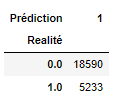

# Chargement des données kmeans 15s, 15p

In [43]:
# Chargement des données kmeans 15s, 15p
# charger les indicateurs

chemin_local = ""

nom_fichier = 'accuracy_kmeans_15s_15p_v1.0.csv'
path = chemin_local+nom_fichier
accuracy_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'precision_kmeans_15s_15p_v1.0.csv'
path = chemin_local+nom_fichier
precision_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'recall_kmeans_15s_15p_v1.0.csv'
path = chemin_local+nom_fichier
recall_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'f1score_kmeans_15s_15p_v1.0.csv'
path = chemin_local+nom_fichier
f1score_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'specificity_kmeans_15s_15p_v1.0.csv'
path = chemin_local+nom_fichier
specificity_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'crosstab_kmeans_15s_15p_v1.0.csv'
path = chemin_local+nom_fichier
crosstab_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

accuracy_v1["evaluateur"] = "accuracy_v1"
precision_v1["evaluateur"] = "precision_v1"
recall_v1["evaluateur"] = "recall_v1"
f1score_v1["evaluateur"] = "f1score_v1"
specificity_v1["evaluateur"] = "specificity_v1"

mesures = pd.concat([accuracy_v1,precision_v1,recall_v1,f1score_v1,specificity_v1])

print(accuracy_v1.head(15))
print("\n")

print(precision_v1.head(15))
print("\n")

print(recall_v1.head(15))
print("\n")

print(f1score_v1.head(15))
print("\n")

print(specificity_v1.head(15))
print("\n")

print(crosstab_v1.head(15))

    k         metric       weights    valeur   evaluateur
0   1      manhattan       uniform  0.780086  accuracy_v1
1   1      manhattan      distance  0.780086  accuracy_v1
2   1      manhattan   weights_sqr  0.780086  accuracy_v1
3   1      manhattan  weights_sqr4  0.780086  accuracy_v1
4   1      manhattan  weights_sqr8  0.780086  accuracy_v1
5   1  nan_euclidean       uniform  0.778911  accuracy_v1
6   1  nan_euclidean      distance  0.778911  accuracy_v1
7   1  nan_euclidean   weights_sqr  0.778911  accuracy_v1
8   1  nan_euclidean  weights_sqr4  0.778911  accuracy_v1
9   1  nan_euclidean  weights_sqr8  0.778911  accuracy_v1
10  1      minkowski       uniform  0.778911  accuracy_v1
11  1      minkowski      distance  0.778911  accuracy_v1
12  1      minkowski   weights_sqr  0.778911  accuracy_v1
13  1      minkowski  weights_sqr4  0.778911  accuracy_v1
14  1      minkowski  weights_sqr8  0.778911  accuracy_v1


    k         metric       weights    valeur    evaluateur
0   1      

# Représentation graphique kmeans 15s, 15p

In [44]:
print("Représentation graphique kmeans 15s, 15p")
print("Affichage des courbes de valeur des indicateurs en fonction du nombre de voisins")

import warnings
from bokeh.util.warnings import BokehUserWarning
# warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.simplefilter(action='ignore', category=BokehUserWarning)
warnings.simplefilter(action = 'ignore',category = UserWarning)



# Code Bokeh sans utiliser de boucle : beaucoup plus rapide et zero lag.

from numpy.lib.utils import source
from bokeh.models.widgets import Panel, Tabs
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool,LassoSelectTool
from bokeh.models.ranges import DataRange1d
from bokeh.colors import RGB
from bokeh.models import LinearColorMapper
from  bokeh.models import PanTool,ResetTool,HoverTool,WheelZoomTool,SaveTool,BoxZoomTool
from bokeh.models import Legend

params = {}

params['nb_voisins'] = np.arange(1,21,1)
params['metric'] = ['manhattan','nan_euclidean','minkowski','chebyshev','cosine','euclidean']
params['weights'] = ['uniform','distance','weights_sqr','weights_sqr4','weights_sqr8']
    
mes_couleurs = ['magenta','maroon','mediumaquamarine','mediumblue','mediumorchid','mediumpurple','mediumseagreen',
                'mediumslateblue','mediumspringgreen','mediumturquoise','mediumvioletred','midnightblue','gold',
                'goldenrod','navy','grey','darksalmon','red','magenta','maroon','mediumaquamarine','mediumblue',
                'mediumslateblue','mediumspringgreen','mediumturquoise','mediumvioletred','midnightblue','gold',
                'goldenrod','navy','grey']
# 9 metrics & 2 weights = 18 curves = 18 colors
# https://docs.bokeh.org/en/2.4.2/docs/reference/colors.html#bokeh-colors-named

# Attention : au moins UNE couleur de plus que le nb courbes !!!
# on utilise la couleur supplémentaire pour colorer le pt quand la souris passe dessus


source1 = ColumnDataSource(accuracy_v1)
source2 = ColumnDataSource(precision_v1)
source3 = ColumnDataSource(recall_v1)
source4 = ColumnDataSource(f1score_v1)
source5 = ColumnDataSource(specificity_v1)

tt1 = [("k", "@k"),("metric", "@metric"),("weights","@weights"),("valeur", "@valeur")]

#tools='hover,xpan,xwheel_zoom,box_zoom,save,reset'
tools=[HoverTool(),BoxZoomTool(), PanTool(),ResetTool()]

##################### Accuracy
p1 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Accuracy",
           toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur1 = []
hover1 = []
legend_item1 = []
g1 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(accuracy_v1['metric'].unique()):
    for j,w in enumerate(accuracy_v1['weights'].unique()):
        ma_source = ColumnDataSource(accuracy_v1[(accuracy_v1['metric']==dist) & (accuracy_v1['weights']==w)])
        g1.append(p1.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],
                           line_width=2)) #,legend_label=dist+'--'+w))
        g1.append(p1.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],
                            size=6)) #,legend_label=dist+'--'+w))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur1.append(p1.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7)) #,legend_label=dist+'--'+w))

        hover1.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur1[-1]]))
        legend_item1.append((dist+'--'+w,[g1[-1],g1[-2],chgt_couleur1[-1]]))

p1.legend.visible = False
legend1 = Legend(items=legend_item1,location="center",click_policy="hide")

p1.add_layout(legend1, 'right')

tab1 = Panel(child=p1, title="Accuracy")

##################### Precision
p2 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Precision",
            x_range = p1.x_range,
            toolbar_location = "below",
            tooltips = tt1,tools = tools)

chgt_couleur2 = []
hover2 = []
legend_item2 = []
g2 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(precision_v1['metric'].unique()):
    for j,w in enumerate(precision_v1['weights'].unique()):
        ma_source = ColumnDataSource(precision_v1[(precision_v1['metric']==dist) & (precision_v1['weights']==w)])
        g2.append(p2.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g2.append(p2.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur2.append(p2.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover2.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur2[-1]]))
        legend_item2.append((dist+'--'+w,[g2[-1],g2[-2],chgt_couleur2[-1]]))

p2.legend.visible = False
legend2 = Legend(items=legend_item2,location="center",click_policy="hide")

p2.add_layout(legend2, 'right')

tab2 = Panel(child=p2, title="Precision")

# ##################### Recall
p3 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Recall",
            x_range = p1.x_range,
            toolbar_location = "below",
            tooltips = tt1,tools = tools)

chgt_couleur3 = []
hover3 = []
legend_item3 = []
g3 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(recall_v1['metric'].unique()):
    for j,w in enumerate(recall_v1['weights'].unique()):
        ma_source = ColumnDataSource(recall_v1[(recall_v1['metric']==dist) & (recall_v1['weights']==w)])
        g3.append(p3.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g3.append(p3.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur3.append(p3.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover3.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur3[-1]]))
        legend_item3.append((dist+'--'+w,[g3[-1],g3[-2],chgt_couleur3[-1]]))

p3.legend.visible = False
legend3 = Legend(items=legend_item3,location="center",click_policy="hide")

p3.add_layout(legend3, 'right')

tab3 = Panel(child=p3, title="Recall")

# ##################### F1-Score
p4 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="F1-Score",
            x_range = p1.x_range,
            toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur4 = []
hover4 = []
legend_item4 = []
g4 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(f1score_v1['metric'].unique()):
    for j,w in enumerate(f1score_v1['weights'].unique()):
        ma_source = ColumnDataSource(f1score_v1[(f1score_v1['metric']==dist) & (f1score_v1['weights']==w)])
        g4.append(p4.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g4.append(p4.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur4.append(p4.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover4.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur4[-1]]))
        legend_item4.append((dist+'--'+w,[g4[-1],g4[-2],chgt_couleur4[-1]]))

p4.legend.visible = False
legend4 = Legend(items=legend_item4,location="center",click_policy="hide")

p4.add_layout(legend4, 'right')

tab4 = Panel(child=p4, title="F1-Score")

# ##################### Specificity
p5 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Specificity",
            x_range = p1.x_range,
            toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur5 = []
hover5 = []
legend_item5 = []
g5 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(specificity_v1['metric'].unique()):
    for j,w in enumerate(specificity_v1['weights'].unique()):
        ma_source = ColumnDataSource(specificity_v1[(specificity_v1['metric']==dist) & (specificity_v1['weights']==w)])
        g5.append(p5.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g5.append(p5.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur5.append(p5.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover5.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur5[-1]]))
        legend_item5.append((dist+'--'+w,[g5[-1],g5[-2],chgt_couleur5[-1]]))
        
p5.legend.visible = False
legend5 = Legend(items=legend_item5,location="center",click_policy="hide")

p5.add_layout(legend5, 'right')

tab5 = Panel(child=p5, title="Specificity")

# ##################### Accuracy en fct du F1-Score

p6 = figure(plot_width=800, plot_height=800,x_axis_label='F1-Score', y_axis_label='Accuracy',
#             title="Accuracy en fct du F1-Score",
            toolbar_location = "below",
           x_range = DataRange1d(bounds='auto'),
           y_range = DataRange1d(bounds='auto'))

acc_f1 = accuracy_v1.copy(deep=True)
acc_f1.rename(columns={'valeur':'accuracy'},inplace=True)

acc_f1['f1score'] = f1score_v1['valeur']
acc_f1['precision'] = precision_v1['valeur']
acc_f1['recall'] = recall_v1['valeur']
acc_f1['specificity'] = specificity_v1['valeur']

acc_f1['id_couleur'] = round(30 * (acc_f1['accuracy'] * acc_f1['f1score']),0).astype(int)
# couleurs arbitraires pour différencier :
# les meilleurs compromis F1Score/Accuracy
# les compromis moyens
# les mauvais compromis

source6 = ColumnDataSource(acc_f1)

ma_cmap = LinearColorMapper(palette=mes_couleurs, 
                             low = min(acc_f1['id_couleur']), 
                             high = max(acc_f1['id_couleur']))
            
p6.circle(x='f1score',y='accuracy',
          fill_color= {"field":"id_couleur", "transform":ma_cmap},
          line_color=None,
          source = source6,
          size=6)

# chgt de couleur qd la souris passe sur un pt
chgt_couleur6 = p6.circle(x='f1score',y='accuracy',source = source6,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7)

tt2 = [("k", "@k"),("metric", "@metric"),("weights","@weights"),("f1score", "@f1score"),("accuracy","@accuracy"),
      ("recall","@recall"),("precision","@precision"),("specificity","@specificity")]

hover6 = HoverTool(
        tooltips=tt2,
        mode='mouse',
        renderers=[chgt_couleur6])

p6.add_tools(hover6)

tab6 = Panel(child=p6, title="Accuracy en fct du F1-Score")

# ##################### Affichages

# h = column(row(p1,p2),row(p3,p4),row(p5,p6))
# show(h)

tabs = Tabs(tabs=[tab6,tab1,tab2,tab3,tab4,tab5])

show(tabs)

Représentation graphique kmeans 15s, 15p
Affichage des courbes de valeur des indicateurs en fonction du nombre de voisins


# KNN sur 100 centroïdes sec et 100 centroïdes pluie

In [45]:
# KNN sur 100 centroïdes sec et 100 centroïdes pluie
# utilisation de Kmeans pour trouver des centroïdes
from sklearn.cluster import KMeans

# création de n centroïdes à partir des échantillons secs
kmeans_sec = KMeans(n_clusters = 100)

kmeans_sec.fit(X_train_minmax_sec)

# création de n centroïdes à partir des échantillons de pluie
kmeans_pluie = KMeans(n_clusters = 100)

kmeans_pluie.fit(X_train_minmax_pluie)

# Création du jeux d'entrainement à partir des centroïdes

centroids_sec = kmeans_sec.cluster_centers_

print(centroids_sec.shape)

centroids_pluie = kmeans_pluie.cluster_centers_

print(centroids_pluie.shape)

X_train_centroids = np.append(centroids_sec,centroids_pluie,axis=0)

print(X_train_centroids.shape)

C:\Users\plebert1\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\plebert1\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(100, 28)
(100, 28)
(200, 28)


# Simulation knn sur centroïdes 100s, 100p

In [46]:
# Simulation knn sur centroïdes 100s, 100p
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

params = {}
params['nb_voisins'] = np.arange(1,21,1)
params['metric'] = ['manhattan','nan_euclidean','minkowski','chebyshev','cosine','euclidean']
params['weights'] = ['uniform','distance','weights_sqr','weights_sqr4','weights_sqr8']

accuracy = []
precision = []
recall = []
f1score = []
specificity = []

CT = []

y = []
for i in np.arange(0,100):
    y.append(0);

for i in np.arange(0,100):
    y.append(1);
    
y_train_centroids = pd.Series(y)

y_predict = pd.DataFrame()

temps_traitement = []
hdebut = datetime.now()
temps_traitement.append(["Début traitement",hdebut])

for i in params['nb_voisins'] :
    for dist in params['metric']:
        for w in params['weights'] :
            
            #initialisation du modèle modèle :            
            if w == 'weights_sqr':
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr, algorithm = "auto", leaf_size = 30, p = 2,
                                       metric = dist, metric_params = None, n_jobs = None)
            elif w == 'weights_sqr4':
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr4, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = dist, metric_params = None, n_jobs = None)
            elif w == 'weights_sqr8':
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr8, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = dist, metric_params = None, n_jobs = None)
            else :
                display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                knn = KNeighborsClassifier(n_neighbors = i, weights = w, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = dist, metric_params = None, n_jobs = None)
                 
            knn.fit(X_train_centroids,y_train_centroids)
        
        
            y_p = knn.predict(X_test_minmax)
            y_prob = knn.predict_proba(X_test_minmax)
            
            col = 'pred'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col] = y_p
            
            col_proba = 'proba0zzz'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col_proba] = y_prob[:,0]
            
            col_proba = 'proba1zzz'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col_proba] = y_prob[:,1]
                             
            ct = pd.crosstab(y_test,y_p,rownames=['Realité'],colnames=['Prédiction'])
            tp = ct.iloc[1,1]
            tn = ct.iloc[0,0]
            fp = ct.iloc[0,1]
            fn = ct.iloc[1,0]
            
            acc = Accuracy(tp,tn,fp,fn)
            pre = Precision(tp,fp)
            rec = Recall(tp,fn)
            f1s = F1score(rec,pre)
            spe = Specificity(tn,fp)
            
            CT.append([i,dist,w,tp,tn,fp,fn,acc,pre,rec,f1s,spe])
                             
            accuracy.append([i,dist,w,acc])
            precision.append([i,dist,w,pre])
            recall.append([i,dist,w,rec])
            f1score.append([i,dist,w,f1s])
            specificity.append([i,dist,w,spe])

hfin = datetime.now()

temps_traitement.append(["Fin traitement",hfin])
temps_traitement.append(["Durée traitement",hfin-hdebut])

warnings.filterwarnings("default", category=FutureWarning)

# Sauvegarde des résultats

# pond_var_inf_mut_"
chemin_local = ""
nom_fichier = 'accuracy_kmeans_100s_100p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=accuracy,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'precision_kmeans_100s_100p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=precision,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'recall_kmeans_100s_100p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=recall,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'f1score_kmeans_100s_100p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=f1score,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'specificity_kmeans_100s_100p_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=specificity,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'y_predict_kmeans_100s_100p_v1.0.csv'
pd.DataFrame(data=y_predict).to_csv(nom_fichier,sep=',')

nom_fichier = 'crosstab_kmeans_100s_100p_v1.0.csv'
pd.DataFrame(data=CT,
             columns=['k','metric','weights','tp','tn','fp','fn',
                      'acc','pre','rec','f1s','spe']).to_csv(nom_fichier,sep=',')

hsav = datetime.now()
temps_traitement.append(["Fin sauvegarde",hsav])
                         
pd.DataFrame(data=temps_traitement,columns =["Type","Valeur"]).head(10)

'calcul en cours : k=20--metric=euclidean--weights=weights_sqr8'

C:\Users\plebert1\AppData\Local\Temp\ipykernel_21040\3330570877.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_predict[col] = y_p
C:\Users\plebert1\AppData\Local\Temp\ipykernel_21040\3330570877.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_predict[col_proba] = y_prob[:,0]
C:\Users\plebert1\AppData\Local\Temp\ipykernel_21040\3330570877.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

Type                      Valeur
0  Début traitement  2023-07-16 20:29:05.255539
1    Fin traitement  2023-07-16 20:31:48.033999
2  Durée traitement              0:02:42.778460
3    Fin sauvegarde  2023-07-16 20:32:12.225537

# Chargement des données kmeans 100s, 100p

In [47]:
# Chargement des données kmeans 100s, 100p
# charger les indicateurs

chemin_local = ""

nom_fichier = 'accuracy_kmeans_100s_100p_v1.0.csv'
path = chemin_local+nom_fichier
accuracy_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'precision_kmeans_100s_100p_v1.0.csv'
path = chemin_local+nom_fichier
precision_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'recall_kmeans_100s_100p_v1.0.csv'
path = chemin_local+nom_fichier
recall_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'f1score_kmeans_100s_100p_v1.0.csv'
path = chemin_local+nom_fichier
f1score_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'specificity_kmeans_100s_100p_v1.0.csv'
path = chemin_local+nom_fichier
specificity_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'crosstab_kmeans_100s_100p_v1.0.csv'
path = chemin_local+nom_fichier
crosstab_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

accuracy_v1["evaluateur"] = "accuracy_v1"
precision_v1["evaluateur"] = "precision_v1"
recall_v1["evaluateur"] = "recall_v1"
f1score_v1["evaluateur"] = "f1score_v1"
specificity_v1["evaluateur"] = "specificity_v1"

mesures = pd.concat([accuracy_v1,precision_v1,recall_v1,f1score_v1,specificity_v1])

print(accuracy_v1.head(15))
print("\n")

print(precision_v1.head(15))
print("\n")

print(recall_v1.head(15))
print("\n")

print(f1score_v1.head(15))
print("\n")

print(specificity_v1.head(15))
print("\n")

print(crosstab_v1.head(15))

    k         metric       weights    valeur   evaluateur
0   1      manhattan       uniform  0.777862  accuracy_v1
1   1      manhattan      distance  0.777862  accuracy_v1
2   1      manhattan   weights_sqr  0.777862  accuracy_v1
3   1      manhattan  weights_sqr4  0.777862  accuracy_v1
4   1      manhattan  weights_sqr8  0.777862  accuracy_v1
5   1  nan_euclidean       uniform  0.778743  accuracy_v1
6   1  nan_euclidean      distance  0.778743  accuracy_v1
7   1  nan_euclidean   weights_sqr  0.778743  accuracy_v1
8   1  nan_euclidean  weights_sqr4  0.778743  accuracy_v1
9   1  nan_euclidean  weights_sqr8  0.778743  accuracy_v1
10  1      minkowski       uniform  0.778743  accuracy_v1
11  1      minkowski      distance  0.778743  accuracy_v1
12  1      minkowski   weights_sqr  0.778743  accuracy_v1
13  1      minkowski  weights_sqr4  0.778743  accuracy_v1
14  1      minkowski  weights_sqr8  0.778743  accuracy_v1


    k         metric       weights    valeur    evaluateur
0   1      

# Représentation graphique kmeans 100s, 100p

In [48]:
print("Représentation graphique kmeans 100s, 100p")
print("Affichage des courbes de valeur des indicateurs en fonction du nombre de voisins")

import warnings
from bokeh.util.warnings import BokehUserWarning
# warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.simplefilter(action='ignore', category=BokehUserWarning)
warnings.simplefilter(action = 'ignore',category = UserWarning)



# Code Bokeh sans utiliser de boucle : beaucoup plus rapide et zero lag.

from numpy.lib.utils import source
from bokeh.models.widgets import Panel, Tabs
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool,LassoSelectTool
from bokeh.models.ranges import DataRange1d
from bokeh.colors import RGB
from bokeh.models import LinearColorMapper
from  bokeh.models import PanTool,ResetTool,HoverTool,WheelZoomTool,SaveTool,BoxZoomTool
from bokeh.models import Legend

params = {}

params['nb_voisins'] = np.arange(1,21,1)
params['metric'] = ['manhattan','nan_euclidean','minkowski','chebyshev','cosine','euclidean']
params['weights'] = ['uniform','distance','weights_sqr','weights_sqr4','weights_sqr8']
    
mes_couleurs = ['magenta','maroon','mediumaquamarine','mediumblue','mediumorchid','mediumpurple','mediumseagreen',
                'mediumslateblue','mediumspringgreen','mediumturquoise','mediumvioletred','midnightblue','gold',
                'goldenrod','navy','grey','darksalmon','red','magenta','maroon','mediumaquamarine','mediumblue',
                'mediumslateblue','mediumspringgreen','mediumturquoise','mediumvioletred','midnightblue','gold',
                'goldenrod','navy','grey']
# 9 metrics & 2 weights = 18 curves = 18 colors
# https://docs.bokeh.org/en/2.4.2/docs/reference/colors.html#bokeh-colors-named

# Attention : au moins UNE couleur de plus que le nb courbes !!!
# on utilise la couleur supplémentaire pour colorer le pt quand la souris passe dessus


source1 = ColumnDataSource(accuracy_v1)
source2 = ColumnDataSource(precision_v1)
source3 = ColumnDataSource(recall_v1)
source4 = ColumnDataSource(f1score_v1)
source5 = ColumnDataSource(specificity_v1)

tt1 = [("k", "@k"),("metric", "@metric"),("weights","@weights"),("valeur", "@valeur")]

#tools='hover,xpan,xwheel_zoom,box_zoom,save,reset'
tools=[HoverTool(),BoxZoomTool(), PanTool(),ResetTool()]

##################### Accuracy
p1 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Accuracy",
           toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur1 = []
hover1 = []
legend_item1 = []
g1 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(accuracy_v1['metric'].unique()):
    for j,w in enumerate(accuracy_v1['weights'].unique()):
        ma_source = ColumnDataSource(accuracy_v1[(accuracy_v1['metric']==dist) & (accuracy_v1['weights']==w)])
        g1.append(p1.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],
                           line_width=2)) #,legend_label=dist+'--'+w))
        g1.append(p1.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],
                            size=6)) #,legend_label=dist+'--'+w))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur1.append(p1.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7)) #,legend_label=dist+'--'+w))

        hover1.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur1[-1]]))
        legend_item1.append((dist+'--'+w,[g1[-1],g1[-2],chgt_couleur1[-1]]))

p1.legend.visible = False
legend1 = Legend(items=legend_item1,location="center",click_policy="hide")

p1.add_layout(legend1, 'right')

tab1 = Panel(child=p1, title="Accuracy")

##################### Precision
p2 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Precision",
            x_range = p1.x_range,
            toolbar_location = "below",
            tooltips = tt1,tools = tools)

chgt_couleur2 = []
hover2 = []
legend_item2 = []
g2 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(precision_v1['metric'].unique()):
    for j,w in enumerate(precision_v1['weights'].unique()):
        ma_source = ColumnDataSource(precision_v1[(precision_v1['metric']==dist) & (precision_v1['weights']==w)])
        g2.append(p2.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g2.append(p2.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur2.append(p2.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover2.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur2[-1]]))
        legend_item2.append((dist+'--'+w,[g2[-1],g2[-2],chgt_couleur2[-1]]))

p2.legend.visible = False
legend2 = Legend(items=legend_item2,location="center",click_policy="hide")

p2.add_layout(legend2, 'right')

tab2 = Panel(child=p2, title="Precision")

# ##################### Recall
p3 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Recall",
            x_range = p1.x_range,
            toolbar_location = "below",
            tooltips = tt1,tools = tools)

chgt_couleur3 = []
hover3 = []
legend_item3 = []
g3 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(recall_v1['metric'].unique()):
    for j,w in enumerate(recall_v1['weights'].unique()):
        ma_source = ColumnDataSource(recall_v1[(recall_v1['metric']==dist) & (recall_v1['weights']==w)])
        g3.append(p3.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g3.append(p3.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur3.append(p3.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover3.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur3[-1]]))
        legend_item3.append((dist+'--'+w,[g3[-1],g3[-2],chgt_couleur3[-1]]))

p3.legend.visible = False
legend3 = Legend(items=legend_item3,location="center",click_policy="hide")

p3.add_layout(legend3, 'right')

tab3 = Panel(child=p3, title="Recall")

# ##################### F1-Score
p4 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="F1-Score",
            x_range = p1.x_range,
            toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur4 = []
hover4 = []
legend_item4 = []
g4 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(f1score_v1['metric'].unique()):
    for j,w in enumerate(f1score_v1['weights'].unique()):
        ma_source = ColumnDataSource(f1score_v1[(f1score_v1['metric']==dist) & (f1score_v1['weights']==w)])
        g4.append(p4.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g4.append(p4.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur4.append(p4.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover4.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur4[-1]]))
        legend_item4.append((dist+'--'+w,[g4[-1],g4[-2],chgt_couleur4[-1]]))

p4.legend.visible = False
legend4 = Legend(items=legend_item4,location="center",click_policy="hide")

p4.add_layout(legend4, 'right')

tab4 = Panel(child=p4, title="F1-Score")

# ##################### Specificity
p5 = figure(plot_width=800, plot_height=800,x_axis_label='k', y_axis_label='valeur',title="Specificity",
            x_range = p1.x_range,
            toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur5 = []
hover5 = []
legend_item5 = []
g5 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(specificity_v1['metric'].unique()):
    for j,w in enumerate(specificity_v1['weights'].unique()):
        ma_source = ColumnDataSource(specificity_v1[(specificity_v1['metric']==dist) & (specificity_v1['weights']==w)])
        g5.append(p5.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g5.append(p5.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur5.append(p5.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover5.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur5[-1]]))
        legend_item5.append((dist+'--'+w,[g5[-1],g5[-2],chgt_couleur5[-1]]))
        
p5.legend.visible = False
legend5 = Legend(items=legend_item5,location="center",click_policy="hide")

p5.add_layout(legend5, 'right')

tab5 = Panel(child=p5, title="Specificity")

# ##################### Accuracy en fct du F1-Score

p6 = figure(plot_width=800, plot_height=800,x_axis_label='F1-Score', y_axis_label='Accuracy',
#             title="Accuracy en fct du F1-Score",
            toolbar_location = "below",
           x_range = DataRange1d(bounds='auto'),
           y_range = DataRange1d(bounds='auto'))

acc_f1 = accuracy_v1.copy(deep=True)
acc_f1.rename(columns={'valeur':'accuracy'},inplace=True)

acc_f1['f1score'] = f1score_v1['valeur']
acc_f1['precision'] = precision_v1['valeur']
acc_f1['recall'] = recall_v1['valeur']
acc_f1['specificity'] = specificity_v1['valeur']

acc_f1['id_couleur'] = round(30 * (acc_f1['accuracy'] * acc_f1['f1score']),0).astype(int)
# couleurs arbitraires pour différencier :
# les meilleurs compromis F1Score/Accuracy
# les compromis moyens
# les mauvais compromis

source6 = ColumnDataSource(acc_f1)

ma_cmap = LinearColorMapper(palette=mes_couleurs, 
                             low = min(acc_f1['id_couleur']), 
                             high = max(acc_f1['id_couleur']))
            
p6.circle(x='f1score',y='accuracy',
          fill_color= {"field":"id_couleur", "transform":ma_cmap},
          line_color=None,
          source = source6,
          size=6)

# chgt de couleur qd la souris passe sur un pt
chgt_couleur6 = p6.circle(x='f1score',y='accuracy',source = source6,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7)

tt2 = [("k", "@k"),("metric", "@metric"),("weights","@weights"),("f1score", "@f1score"),("accuracy","@accuracy"),
      ("recall","@recall"),("precision","@precision"),("specificity","@specificity")]

hover6 = HoverTool(
        tooltips=tt2,
        mode='mouse',
        renderers=[chgt_couleur6])

p6.add_tools(hover6)

tab6 = Panel(child=p6, title="Accuracy en fct du F1-Score")

# ##################### Affichages

# h = column(row(p1,p2),row(p3,p4),row(p5,p6))
# show(h)

tabs = Tabs(tabs=[tab6,tab1,tab2,tab3,tab4,tab5])

show(tabs)

Représentation graphique kmeans 100s, 100p
Affichage des courbes de valeur des indicateurs en fonction du nombre de voisins
